# Proyecto B Etapa 2 Modelado, Simulación y Optimización

Integrantes:

• Laura Valentina Lara Díaz - 201912967

• Mateo Calderón Rincón - 202213589

• Alejandro lancheros - 202122797

# Implementación del modelo matemático

## Modelo matemático caso base

El siguiente modelo matemático se usó para todos los casos como base, aunque bien es necesario mencionar que todos los casos no son iguales, si tienen mucho en común. Por ello con el fin de no repetir información del modelo hemos decidido dejar este modelo base y luego aclarar las adiciones y/o modificaciones que este modelo tenga respecto a los de los otros casos.


#### **Parámetros**

- Conjunto de nodos:
  $$
  N = {0, 1, 2, ..., n}
  $$
  Donde (0) representa el depósito y (1, 2, ..., n) son los clientes.

- Conjunto de clientes:
  $$
  C = {1, 2, ... , n}
  $$

- Conjunto de vehículos:
  $$
  V = {1, 2, ... , m}
  $$

- Demanda de cada cliente $(j \in C$):
  $$
  d_j
  $$

- Capacidad de cada vehículo $(v \in V$):
  $$
  q_v
  $$

- Distancia entre nodos $(i, j \in N$):
  $$
  \text{dist}_{i,j}
  $$

- Tiempo entre nodos $(i, j \in N$):
  $$
  t_{i,j}
  $$

- Costos:
  - Precio del combustible por litro:
    $$
    P_f
    $$
  - Costo de mantenimiento por kilómetro:
    $$
    C_m
    $$
  - Costo eléctrico:
    $$
    C_e
    $$
  - Tarifa fija por kilómetro:
    $$
    F_t
    $$
  - Costo por viaje:
    $$
    C_v
    $$

- Parámetro binario que indica si un vehículo es una camioneta:
  $$
  \delta_v = 1 \quad \text{(para todos los vehículos, ya que son camionetas)}
  $$

---

#### **Variables**

- Variable binaria que indica si el vehículo \(v\) viaja del nodo \(i\) al nodo \(j\):
  $$
  x_{i,j,v} \in \{0, 1\}
  $$

- Carga acumulada en el vehículo \(v\) al llegar al cliente \(j\):
  $$
  u_{j,v} \geq 0
  $$

---

#### **Función Objetivo**

Minimizar el costo total del recorrido:
$$
\text{Minimizar: } \sum_{v \in V} \sum_{i \in N} \sum_{j \in N, i \neq j} \left( P_f \cdot \text{dist}_{i,j} \cdot \delta_v + C_m + \delta_v \cdot C_e + F_t + C_v \cdot t_{i,j} \right) \cdot x_{i,j,v}
$$

---

#### **Restricciones**

1. **Cada cliente debe ser visitado exactamente una vez**:
   $$
   \sum_{i \in N} \sum_{v \in V} x_{i,j,v} = 1 \quad \forall j \in C
   $$

2. **Cada cliente debe tener una salida**:
   $$
   \sum_{k \in N} \sum_{v \in V} x_{j,k,v} = 1 \quad \forall j \in C
   $$

3. **Conservación de flujo en cada cliente**:
   $$
   \sum_{i \in N} x_{i,j,v} - \sum_{k \in N} x_{j,k,v} = 0 \quad \forall j \in C, \forall v \in V
   $$

4. **Restricción de subtours (MTZ)**:
   $$
   u_{i,v} + d_j - u_{j,v} \leq q_v \cdot (1 - x_{i,j,v}) \quad \forall i, j \in C, i \neq j, \forall v \in V
   $$

5. **Límites de la carga acumulada**:
   $$
   d_j \leq u_{j,v} \leq q_v \quad \forall j \in C, \forall v \in V
   $$

6. **Capacidad total del vehículo**:
   $$
   \sum_{i \in N} \sum_{j \in C, i \neq j} d_j \cdot x_{i,j,v} \leq q_v \quad \forall v \in V
   $$

7. **Restricción de salida desde el depósito**:
   $$
   \sum_{j \in C} x_{0,j,v} \leq 1 \quad \forall v \in V
   $$

8. **Restricción de entrada al depósito**:
   $$
   \sum_{i \in C} x_{i,0,v} \leq 1 \quad \forall v \in V
   $$




## Modelo matemático caso 2

Para este caso, se agregan las ventanas de tiempo al modelo, es por ello que se adicionan estas dos restricciones a las que se tenían en el modelo base:

9. **Restricción Inferior de la Ventana de Tiempo:**

 $$ t_{j,v}^{\text{arrival}} \geq \text{start}_j \quad \forall j \in C, \forall v \in V $$

10. **Restricción Superior de la Ventana de Tiempo:**

$$ t_{j,v}^{\text{arrival}} \leq \text{end}_j \quad \forall j \in C, \forall v \in V $$

## Modelo matemático caso 3

# Procesamiento de datos

Como el caso que estamos resolviendo emplea distintos tipos de vehículos, que se desplazan de forma diferente entre ellos, es necesario definir como se van a registrar las distancias entre los depósitos y los clientes para de esta forma calcular la mejor manera las rutas para que los clientes puedan satisfacer sus demandas teniendo en cuenta los vehículos. De acuerdo con la información suministrada se tienen dos tipos de vehículos para realizar las entregas, camionetas y drones, los cuales tienen condiciones distintas, ya que las camionetas dependen totalmente de las carreteras que conectan a esos puntos, mientras que los drones no las necesitan para realizar sus desplazamientos. Adicionalmente, los drones se pueden mover en línea recta, permitiendo que la distancia entre los puntos que se quieran analizar sea calculada de forma diferente a la que se quiere hacer con las camionetas.

Para el calculo de la distancia y tiempo entre los puntos (entiéndanse como depósitos y clientes) para las camionetas, se hace uso del API de OpenRouteService, la cual permite calcular la distancia entre dos puntos basada en los caminos existentes y el tiempo de desplazamiento basado en la información que se tenga. A continuación, se presenta el código empleado para obtener dichos tiempos y distancias basadas en la longitud y latitud de cada punto, estos datos quedan guardados en un archivo JSON que se usará luego para construir los grafos de cada uno de los casos, por lo que sencillamente para cada caso lo que se cambian son los datos que se le pasan al API para el cálculo de los datos. Es importante resaltar que si el API retorna error para calcular algún camino, se considera que no es posible que una camioneta realice el desplazamiento ya que no existen caminos entre estos puntos, por lo que se usan valores altos en estos casos, al igual que cuando se tratan de calcular las diagonales de la matriz (distancia del depósito 1 con el depósito 1), donde también se usan valores altos.

**Aclaración importante:** puede que al momento de probar el siguiente código retorne error, ya que el API al ser gratuita tiene ciertos limites, por lo que en algunos casos al querer correr este código puede que retorne error por lo mencionado anteriormente. 

In [ ]:
import pandas as pd
import requests
import time
import pprint
import json

# === Cargar archivos
clients = pd.read_csv("data-caso1/clients.csv")
depots  = pd.read_csv("data-caso1/depots.csv")

# === Coordenadas
nodes = {
    0: (
        depots.loc[0, "Longitude"],
        depots.loc[0, "Latitude"]
    )
}
for _, row in clients.iterrows():
    node_id = int(row["ClientID"])
    coord   = (row["Longitude"], row["Latitude"])
    nodes[node_id] = coord

# === Configuración de API
api_key = '5b3ce3597851110001cf6248f4bace05742cd52a0f6b877ce5d52bffe229f05a5f3132ac87cef6d3'
headers = {
    'Authorization': api_key,
    'Content-Type': 'application/json'
}
url = 'https://api.openrouteservice.org/v2/directions/driving-car'

# === Crear grafo (matriz de distancias y tiempos)
grafo = {}

for i, coords_i in nodes.items():
    grafo[i] = {}
    for j, coords_j in nodes.items():
        if i == j:
            # Sin desplazamiento: valor "infinito"
            grafo[i][j] = (999.0, 999.0)
            continue

        params = {
            'start': f"{coords_i[0]},{coords_i[1]}",
            'end':   f"{coords_j[0]},{coords_j[1]}"
        }

        response = requests.get(url, headers=headers, params=params)
        time.sleep(1.6)  # para no sobrepasar el rate-limit

        if response.status_code == 200:
            seg   = response.json()['features'][0]['properties']['segments'][0]
            dist  = round(seg['distance'] / 1000, 2)
            tiem  = round(seg['duration'] / 60, 2)
            if dist == 0.0: dist = 999.0
            if tiem == 0.0: tiem = 999.0
            grafo[i][j] = (dist, tiem)

        elif response.status_code == 404:
            # ruta no encontrada
            grafo[i][j] = (999.0, 999.0)

        else:
            # otros errores HTTP
            print(f"Error {response.status_code}: {response.text}")
            grafo[i][j] = (999.0, 999.0)


# === Guardar en JSON
with open("json-resultados-api/distancias-tiempo-api-carro-1.json", "w") as f:
    json.dump(grafo, f, indent=2)


Este código generó 3 archivos JSON distintos, cada uno para un caso distinto, los archivos reciben los nombres "distancias-tiempo-api-carro-#" siendo # el número del caso para el cuál se están calculando los datos.


Esta imagen muestra la composición de los archivos:

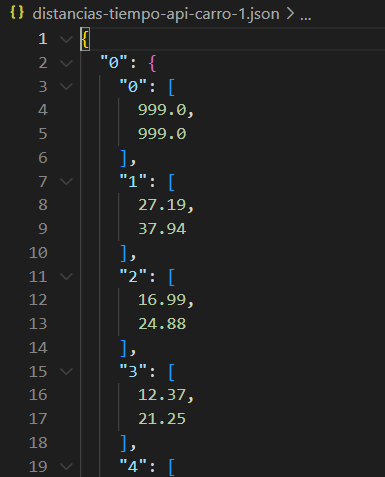

Ahora, es necesario implementar un código que tome estos JSON con los resultados del API y permita generar un grafo, esto con el objetivo de tener los datos listos para entregarselos al modelo y que de esa forma pueda solucionarse el problema. 

El código siguiente es el que toma los archivos JSON y genera grafos con las distancias y tiempos para trayecto. Esta es la implementación que se usó en cada uno de los casos:

In [4]:
import json
import pprint

# Cargar el archivo JSON 
with open('json-resultados-api/distancias-tiempo-api-carro-1.json', 'r') as f:
    data = json.load(f)

# Reconstruir grafo
grafo1 = {}
for origen_str, destinos in data.items():
    origen = int(origen_str)
    grafo1[origen] = {}
    for destino_str, valores in destinos.items():
        destino = int(destino_str)

        dist, tiem = valores

        if dist == 0.0: dist = 999.0
        if tiem == 0.0: tiem = 999.0
        grafo1[origen][destino] = (dist, tiem)


Esta es la estructura del grafo resultante del código anterior, el primer valor contiene la distancia en km y la segunda el tiempo en minutos

In [5]:
print(grafo1)

{0: {0: (999.0, 999.0), 1: (27.19, 37.94), 2: (16.99, 24.88), 3: (12.37, 21.25), 4: (26.7, 37.46), 5: (22.64, 37.66), 6: (19.65, 30.32), 7: (25.02, 41.42), 8: (23.89, 39.78), 9: (30.67, 45.27), 10: (33.86, 48.42), 11: (33.49, 45.98), 12: (15.87, 25.26), 13: (21.66, 32.79), 14: (10.36, 18.26), 15: (26.79, 37.02), 16: (33.91, 49.26), 17: (26.61, 40.59), 18: (19.87, 34.03), 19: (20.93, 29.42), 20: (13.14, 21.99), 21: (27.84, 38.78), 22: (24.41, 33.01), 23: (11.34, 19.85), 24: (30.87, 45.29)}, 1: {0: (30.96, 40.45), 1: (999.0, 999.0), 2: (14.29, 20.42), 3: (19.44, 24.53), 4: (1.13, 3.0), 5: (12.5, 18.04), 6: (11.32, 18.15), 7: (17.81, 34.15), 8: (13.75, 20.17), 9: (7.51, 11.23), 10: (7.39, 12.68), 11: (10.33, 11.93), 12: (25.81, 31.21), 13: (8.3, 14.06), 14: (20.31, 24.21), 15: (1.29, 2.81), 16: (7.44, 13.51), 17: (4.49, 10.82), 18: (9.84, 16.34), 19: (14.97, 23.16), 20: (23.09, 27.94), 21: (21.68, 31.86), 22: (5.38, 8.34), 23: (21.29, 25.8), 24: (4.89, 9.97)}, 2: {0: (18.34, 23.89), 1: (1

Adicionalmente, para calcular las distancias y tiempos que tomarían los drones en desplazarse entre los distintos puntos, debemos recordar que estos se mueven en línea recta se hizo uso de la función de Haversine, la cual permite calcular la distancia más corta entre dos puntos en la superficie de una esfera, en este caso la Tierra, para ello se usan las coordenadas proporcionadas para cada uno de los depósitos y clientes (latitud y longitud):

$$
d = 2r \cdot \arcsin\left( 
\sqrt{ 
\sin^2\left( \frac{\phi_2 - \phi_1}{2} \right) 
+ \cos(\phi_1) \cos(\phi_2) \sin^2\left( \frac{\lambda_2 - \lambda_1}{2} \right) 
} 
\right)
$$

Esta es la implementación que toma los datos de los casos 2 y 3, y en base a ello calcula las distancias y el tiempo usando la función anteriormente descrita, a continuación, se muestra la implementación usada:

In [6]:
import math
import pandas as pd

# Función para calcular la distancia entre dos puntos geográficos usando longitud y latitud
def haversine(coord1, coord2):
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    
    R = 6371.0  # Radio de la Tierra en km
    
    # Grados a radianes
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    
    # Fórmula matemática
    a = math.sin(delta_phi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    distance = R * c
    return distance

# Cargar datos de clientes y depósito
clients = pd.read_csv("data-caso2/clients.csv")
depots = pd.read_csv("data-caso2/depots.csv")

# Crear un diccionario de nodos con coordenadas
nodes = {}

# Agregar el depósito como nodo central
for _, row in depots.iterrows():
    nodes[row["LocationID"]] = (row["Longitude"], row["Latitude"])

# Agregar los clientes como nodos
for _, row in clients.iterrows():
    nodes[row["LocationID"]] = (row["Longitude"], row["Latitude"])

# Cargar datos de vehículos
vehicles = pd.read_csv("data-caso2/vehicles.csv")

# Filtrar solo los vehículos cuyo Type sea 'drone'
drones = vehicles[vehicles["Type"] == "drone"]

# Crear un diccionario para almacenar las velocidades de los drones
drone_speeds = dict(zip(drones["VehicleID"], drones["Speed"]))

# Diccionario para almacenar el grafo de distancias y tiempos para drones
graphdron = {}

for i, coord_i in nodes.items():
    graphdron[i] = {}  # Inicializar el nodo en el grafo
    for j, coord_j in nodes.items():
        if i == j:
            # Si son el mismo nodo, asignar valores grandes
            graphdron[i][j] = (999, 999)  # Distancia y tiempo grandes
        else:
            # Calcular la distancia usando la fórmula de Haversine
            distance_km = haversine(coord_i, coord_j)
            # Calcular el tiempo promedio para drones (usando la velocidad promedio de los drones)
            if len(drone_speeds) > 0:
                avg_speed_km_min = sum(float(speed) for speed in drone_speeds.values() if speed != "N/A") / (60.0 * len(drone_speeds))
                duration_min = distance_km / avg_speed_km_min
                graphdron[i][j] = (round(distance_km, 3), round(duration_min, 3))
            else:
                # Si no hay velocidad disponible, asignar valores grandes
                graphdron[i][j] = (999, 999)


Este es el grafo que arroja el código anterior después de usar la función de Haversine para el calculo de distancias y tiempos para los drones:

In [230]:
pprint.pprint(graphdron)

{0.0: {0.0: (999, 999),
       1: (2.646, 1.176),
       2: (0.894, 0.397),
       3: (5.297, 2.354),
       4: (2.712, 1.205),
       6: (3.247, 1.443),
       7: (2.286, 1.016),
       8: (3.701, 1.645),
       9: (2.164, 0.962),
       10: (3.017, 1.341),
       11: (4.091, 1.818),
       12: (1.279, 0.569),
       13: (1.612, 0.716),
       14: (3.708, 1.648)},
 1: {0.0: (2.646, 1.176),
     1: (999, 999),
     2: (3.38, 1.502),
     3: (6.25, 2.778),
     4: (3.391, 1.507),
     6: (1.741, 0.774),
     7: (4.763, 2.117),
     8: (4.977, 2.212),
     9: (4.642, 2.063),
     10: (1.335, 0.593),
     11: (5.769, 2.564),
     12: (2.396, 1.065),
     13: (1.573, 0.699),
     14: (2.806, 1.247)},
 2: {0.0: (0.894, 0.397),
     1: (3.38, 1.502),
     2: (999, 999),
     3: (5.818, 2.586),
     4: (3.457, 1.536),
     6: (4.135, 1.838),
     7: (1.414, 0.628),
     8: (4.196, 1.865),
     9: (2.047, 0.91),
     10: (3.475, 1.544),
     11: (4.392, 1.952),
     12: (1.362, 0.605),
     13

# Resolución del modelo, análisis de resultados y visualización

# Caso 1

Como lo mencionamos en la etapa de procesamiento de datos, tenemos que extraer la información del archivo JSON que contiene las distancias y el tiempo calculados para la camioneta, con el objetivo de formar un grafo que nos ayude a organizar la información para usarla en el modelo. Pero primero es importante definir algo, como en los datos del 'Proyecto Base' en el archivo de vehicles.csv, no tenemos indicado el tipo de vehículo que es cada uno de ellos, hemos decidido dejar a todos los vehículos como camionetas 4x4. 

Por lo tanto, aquí tenemos el código que como se mencionaba anteriormente permite construir el grafo con la distancia (km) y el tiempo (min)

In [7]:
import pandas as pd
import openrouteservice as ors

# Configuración del cliente de OpenRouteService con la llave API
client = ors.Client(key="5b3ce3597851110001cf6248685dee6e2f98402882683cd17ed2a892")

# Carga de los datos del centro de distribución y los clientes
centro_distribucion = {"Longitude": -74.153536, "Latitude": 4.743359}
clients = pd.read_csv("data-caso1/clients.csv")

# Creación de la lista de ubicaciones (centro de distribución y clientes)
locations = [[centro_distribucion["Longitude"], centro_distribucion["Latitude"]]]
locations.extend(clients[["Longitude", "Latitude"]].values.tolist())

# Generación de la matriz de distancias y tiempos
try:
    matrix = client.distance_matrix(
        locations=locations,
        profile='driving-car',
        sources=list(range(len(locations))),
        destinations=list(range(len(locations))),
        metrics=['distance', 'duration'],
    )
except Exception as e:
    print(f"Error al generar la matriz: {e}")
    matrix = None

# Procesamiento de la matriz de distancias y tiempos
if matrix:
    distances = matrix['distances']  # Distancias en metros
    durations = matrix['durations']  # Duraciones en segundos

    # Conversión de las distancias a kilómetros y los tiempos a minutos
    distances_km = [[dist / 1000 for dist in row] for row in distances]  # Convertir metros a kilómetros
    durations_min = [[dur / 60 for dur in row] for row in durations]  # Convertir segundos a minutos

    # Conversión de las matrices a DataFrames de pandas
    distances_df = pd.DataFrame(distances_km, index=range(len(locations)), columns=range(len(locations)))
    durations_df = pd.DataFrame(durations_min, index=range(len(locations)), columns=range(len(locations)))

    # Guardado de las matrices en archivos CSV
    distances_df.to_csv("data-caso1/generated_distances_km.csv", index=True, header=True)
    durations_df.to_csv("data-caso1/generated_durations_min.csv", index=True, header=True)

    print("Matrices de distancias (km) y tiempos (min) generadas y guardadas en archivos CSV.")
else:
    print("No se pudo generar la matriz.")

Matrices de distancias (km) y tiempos (min) generadas y guardadas en archivos CSV.


In [8]:
import pandas as pd
import json

# Carga las matrices de distancias y tiempos desde los archivos CSV
camion_distancias = pd.read_csv("data-caso1/generated_distances_km.csv", index_col=0)
camion_tiempos = pd.read_csv("data-caso1/generated_durations_min.csv", index_col=0)


camion_distancias.index = camion_distancias.index 
camion_distancias.columns = camion_distancias.columns.astype(int) 
camion_tiempos.index = camion_tiempos.index 
camion_tiempos.columns = camion_tiempos.columns.astype(int) 

# Creación de  diccionario para almacenar las distancias y tiempos en el formato deseado
distancias_tiempos = {}

for i in camion_distancias.index:
    distancias_tiempos[i] = {}
    for j in camion_distancias.columns:
        distancia = camion_distancias.loc[i, j]
        tiempo = camion_tiempos.loc[i, j]
        distancias_tiempos[i][j] = [distancia, tiempo]


distancias_tiempos_json = json.dumps(distancias_tiempos, indent=2)

with open("json-resultados-api/distancias_tiempos.json", "w") as f:
    f.write(distancias_tiempos_json)

print("distancias_tiempos.json creado con éxito.")

distancias_tiempos.json creado con éxito.


In [9]:
import json

# Cargar el archivo JSON
with open('json-resultados-api/distancias-tiempo-api.json', 'r') as f:
    data = json.load(f)

# Crear la variable grafo
grafo1 = {}

for origen, destinos in data.items():
    grafo1[int(origen)] = {}
    for destino, valores in destinos.items():
        distancia = valores['distance_km']
        tiempo = valores['time_min']
        if distancia == 0.0:
            distancia = 999.0
        if tiempo == 0.0:
            tiempo = 999.0
        grafo1[int(origen)][int(destino)] = (distancia, tiempo)




A continuación, se incluye la implementación del modelo en pyomo para solucionar el problema teniendo en cuenta que no se consideran ventanas de tiempo ni reabastecimiento:

In [10]:
from pyomo.environ import (
    ConcreteModel, Set, Param, Var, Binary, NonNegativeReals,
    Objective, Constraint, minimize, SolverFactory
)
import pandas as pd

# Datos 
clients = pd.read_csv("data-caso1/clients.csv")
vehicles = pd.read_csv("data-caso1/vehicles.csv")

clientes = clients["ClientID"].tolist()
vehiculos = vehicles["VehicleID"].tolist()
nodos = [0] + clientes

demanda = dict(zip(clients["ClientID"], clients["Demand"]))
capacidad = dict(zip(vehicles["VehicleID"], vehicles["Capacity"]))


distancias = {(i,j): grafo1[i][j][0] for i in nodos for j in nodos if i!=j}
tiempos    = {(i,j): grafo1[i][j][1] for i in nodos for j in nodos if i!=j}

# Construcción del modelo 
model = ConcreteModel()

model.N = Set(initialize=nodos)
model.C = Set(initialize=clientes)
model.V = Set(initialize=vehiculos)

model.d = Param(model.C, initialize=demanda) # demanda de los clientes
model.q = Param(model.V, initialize=capacidad) # capacidad de los vehículos
model.dist = Param(model.N, model.N, initialize=distancias, default=1e6)
model.t = Param(model.N, model.N, initialize=tiempos, default=0)

# Costos 
model.Pf = Param(initialize=15000)   # precio combustible por litro
model.Cm = Param(initialize=700)     # costo mantenimiento por km
model.Ce = Param(initialize=0)       # costo eléctrico
model.Ft = Param(initialize=5000)    # tarifa fija por km
model.Cv = Param(initialize=0)       # costo por viaje

# δ_v = 1 para todos los vehículos (todos camionetas)
delta = { v: 1 for v in vehiculos }
model.delta = Param(model.V, initialize=delta)

# Variables
model.x = Var(model.N, model.N, model.V, domain=Binary)
model.u = Var(model.C, model.V, domain=NonNegativeReals)

# Función Objetivo
def obj_custom(m):
    return sum((m.Pf * m.dist[i,j] * m.delta[v] + m.Cm + m.delta[v] * m.Ce + m.Ft + m.Cv * m.t[i,j]) * m.x[i,j,v] for i in m.N for j in m.N for v in m.V if i!=j)
model.obj = Objective(rule=obj_custom, sense=minimize)



# Restricciones
def cliente_una_vez(m, j):
    return sum(m.x[i,j,v] for i in m.N for v in m.V if i!=j) == 1

def cliente_salida(m, j):
    return sum(m.x[j,k,v] for k in m.N for v in m.V if j!=k) == 1

def flujo_cliente(m, j, v):
    return (sum(m.x[i,j,v] for i in m.N if i!=j) - sum(m.x[j,k,v] for k in m.N if k!=j)) == 0

def mtz_rule(m, i, j, v):
    if i!=j:
        return m.u[i,v] + m.d[j] - m.u[j,v] <= m.q[v]*(1 - m.x[i,j,v])
    return Constraint.Skip

def limites_u(m, i, v):
    return (m.d[i], m.u[i,v], m.q[v])

def capacidad_total(m, v):
    return sum(m.d[j]*m.x[i,j,v]
               for i in m.N for j in m.C if i!=j) <= m.q[v]


model.cliente_una_vez = Constraint(model.C, rule=cliente_una_vez)
model.cliente_salida = Constraint(model.C, rule=cliente_salida)
model.flujo = Constraint(model.C, model.V, rule=flujo_cliente)
model.salida_dep = Constraint(model.V, rule=lambda m,v: sum(m.x[0,j,v] for j in m.C) <= 1)
model.entrada_dep = Constraint(model.V, rule=lambda m,v: sum(m.x[i,0,v] for i in m.C) <= 1)
model.mtz = Constraint(model.C, model.C, model.V, rule=mtz_rule)
model.lim_u = Constraint(model.C, model.V, rule=limites_u)
model.cap_total = Constraint(model.V, rule=capacidad_total)

# Solución del modelo
solver = SolverFactory("glpk")
solver.options["tmlim"]  = 60     # segundos máximo
solver.options["mipgap"] = 0.05   # gap 5%
results = solver.solve(model, tee=True)

print("Status:     ", results.solver.status)
print("Termination:", results.solver.termination_condition)
print("Obj. value: ", model.obj())

# Print resultados
print("\n RUTAS ASIGNADAS POR VEHÍCULO:")
for v in model.V:
    rutas, actual, visitados = [], 0, set()
    while True:
        nxt = next(
            (j for j in model.N if j!=actual and model.x[actual,j,v].value>0.5),
            None
        )
        if nxt is None or nxt in visitados:
            break
        rutas.append((actual, nxt))
        visitados.add(nxt)
        actual = nxt
    print(f" Vehículo {v}: {rutas or 'no asignado'}")




GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --tmlim 60 --mipgap 0.05 --write C:\Users\57314\AppData\Local\Temp\tmpqy69_dmu.glpk.raw
 --wglp C:\Users\57314\AppData\Local\Temp\tmppcmsc5m0.glpk.glp --cpxlp C:\Users\57314\AppData\Local\Temp\tmpmbu5b5oa.pyomo.lp
Reading problem data from 'C:\Users\57314\AppData\Local\Temp\tmpmbu5b5oa.pyomo.lp'...
C:\Users\57314\AppData\Local\Temp\tmpmbu5b5oa.pyomo.lp:62050: warning: lower bound of variable 'x2' redefined
C:\Users\57314\AppData\Local\Temp\tmpmbu5b5oa.pyomo.lp:62050: warning: upper bound of variable 'x2' redefined
5064 rows, 4992 columns, 37056 non-zeros
4800 integer variables, all of which are binary
66850 lines were read
Writing problem data to 'C:\Users\57314\AppData\Local\Temp\tmppcmsc5m0.glpk.glp'...
56979 lines were written
GLPK Integer Optimizer 5.0
5064 rows, 4992 columns, 37056 non-zeros
4800 integer variables, all of which are binary
Preprocessing...
4680 rows, 4992 columns, 36672 non-zeros
4800 integ

A continuación, se tiene el código que permite generar el archivo de verificación para este problema, para ello las columnas que se han contemplado para este archivo son las siguientes:

| VehicleId | VehicleType | InitialLoad | RouteSequence| ClientsServed | DemandSatisfied | TotalDistance | TotalTime | Cost |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| Identificador único del vehículo, es el mismo valor que se encuentra en el archivo vehicles.csv del caso base | Tipo de vehículo, en este caso todos son trucks | Carga inicial del vehículo al salir del centro de distribución | Secuencia completa de la ruta incluyendo el CD inicial, los clientes (que aparecen de la forma 'COMXX') y los retornos al CD | Número total de clientes atendidos por el vehículo | Lista de demandas satisfechas por cada cliente en el orden visitado | Distancia total recorrida (en km) | Tiempo total de la ruta (en minutos) | Costo total de operación para la ruta (en COP) | 

In [11]:
import pandas as pd

clients_df = pd.read_csv("data-caso1/clients.csv")

records = []
for v in model.V:
    vid       = v
    v_str     = str(v)
    vtype     = "Drone" if v_str.upper().startswith("DRN") else "Truck"
    init_load = float(model.q[v])

    seq        = ["CD"]
    current    = 0
    total_dist = 0.0
    total_time = 0.0
    total_cost = 0.0
    demands    = []

    while True:
        nxt = None
        for j in model.C:
            val = getattr(model.x[current, j, v], "value", None)
            if val is not None and val > 0.5:
                nxt = j
                break
        if nxt is None:
            break

        dist_ij = float(model.dist[current, nxt])
        time_ij = float(model.t[current, nxt])
        cost_ij = (
            model.Pf * dist_ij * model.delta[v]
            + model.Cm
            + model.delta[v] * model.Ce
            + model.Ft
            + model.Cv * time_ij
        )
        total_dist += dist_ij
        total_time += time_ij
        total_cost += cost_ij

        demands.append(int(model.d[nxt]))
        seq.append(f"COM{int(nxt):02d}")
        current = nxt

    ret_val = getattr(model.x[current, 0, v], "value", None)
    if ret_val is not None and ret_val > 0.5:
        dist_ij = float(model.dist[current, 0])
        time_ij = float(model.t[current, 0])
        cost_ij = (model.Pf * dist_ij * model.delta[v] + model.Cm + model.delta[v] * model.Ce + model.Ft + model.Cv * time_ij)
        total_dist += dist_ij
        total_time += time_ij
        total_cost += cost_ij
        seq.append("CD")

    records.append({
        "VehicleId":       vid,
        "VehicleType":     vtype,
        "InitialLoad":     round(init_load, 2),
        "RouteSequence":   "-".join(seq),
        "ClientsServed":   len(demands),
        "DemandSatisfied": "-".join(str(d) for d in demands),
        "TotalDistance":   round(total_dist, 2),
        "TotalTime":       round(total_time, 2),
        "Cost":            round(total_cost, 2),
    })

# Guardar CSV
df_verif = pd.DataFrame(records)
df_verif.to_csv("verification/verification_case1.csv", index=False)


El archivo de verificación fue guardado en el directorio *verification*

In [12]:
import pandas as pd
from IPython.display import display

df = pd.read_csv("verification/verification_case1.csv")
display(df)


,VehicleId,VehicleType,InitialLoad,RouteSequence,ClientsServed,DemandSatisfied,TotalDistance,TotalTime,Cost
0,1,Truck,130.0,CD,0,NaN,0.00,0.00,0.0
1,2,Truck,140.0,CD-COM13-COM04-COM24-COM01-COM15-COM17-COM11-C...,8,21-15-11-13-17-25-17-20,91.73,145.54,1427250.0
2,3,Truck,120.0,CD,0,NaN,0.00,0.00,0.0
3,4,Truck,100.0,CD-COM14-COM23-COM20-COM12-CD,4,15-15-15-12,35.66,59.51,563400.0
4,5,Truck,70.0,CD-COM02-COM07-COM21-COM19-COM03-CD,5,15-17-14-11-12,61.75,122.03,960450.0
5,6,Truck,55.0,CD,0,NaN,0.00,0.00,0.0
6,7,Truck,110.0,CD,0,NaN,0.00,0.00,0.0
7,8,Truck,114.0,CD-COM16-COM10-COM08-COM05-COM06-COM22-COM18-CD,7,10-15-20-20-17-18-12,102.61,166.64,1584750.0


#### Visualización y análisis de resultados

En esta parte del documento, se procederá a realizar diferentes visualizaciones que permitan entender mejor la solución del modelo para este caso y también poder analizarlas en el contexto del problema, para ello se incluirán diferentes graficas.

C:\Users\57314\AppData\Local\Temp\ipykernel_5712\1697471013.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10', len(vehicles))


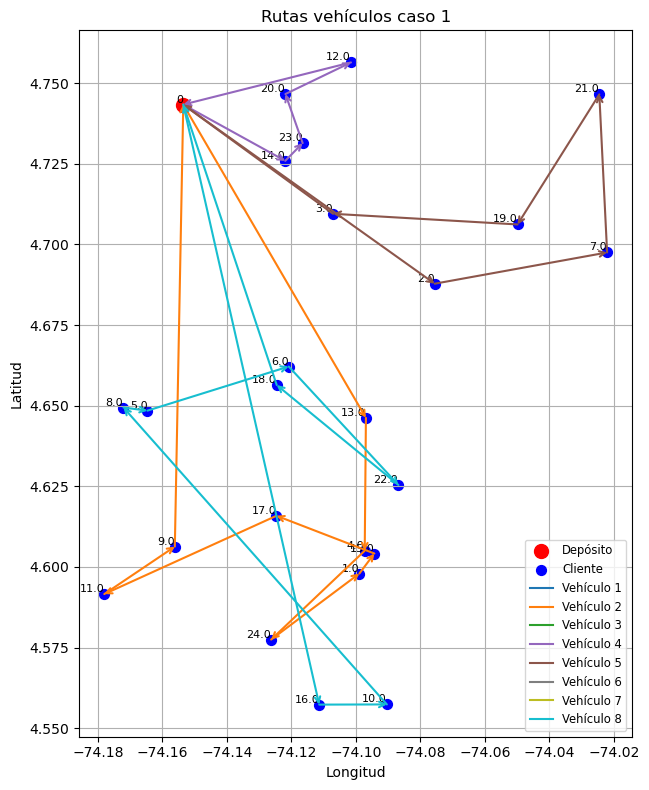

In [13]:
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

clients = pd.read_csv('data-caso1/clients.csv')
depots  = pd.read_csv('data-caso1/depots.csv') 

depot = depots.iloc[0]
coords = { 0: (depot.Longitude, depot.Latitude) }
for _, row in clients.iterrows():
    coords[row.ClientID] = (row.Longitude, row.Latitude)

# Figura
fig, ax = plt.subplots(figsize=(10, 8))
for node, (x, y) in coords.items():
    if node == 0:
        ax.scatter(x, y, c='red', s=100, label='Depósito')
    else:
        label = 'Cliente' if 'Cliente' not in ax.get_legend_handles_labels()[1] else ""
        ax.scatter(x, y, c='blue', s=50, label=label)
    ax.text(x, y, str(node), fontsize=8, ha='right', va='bottom')

# Lineas de ruta
vehicles = list(model.V)
cmap = get_cmap('tab10', len(vehicles))
for idx, v in enumerate(vehicles):
    color = cmap(idx)
    for i in model.N:
        for j in model.N:
            if i != j and model.x[i, j, v].value > 0.5:
                x1, y1 = coords[i]
                x2, y2 = coords[j]
                ax.annotate(
                    '', 
                    xy=(x2, y2), 
                    xytext=(x1, y1),
                    arrowprops=dict(
                        arrowstyle='->',
                        color=color,
                        lw=1.5,
                        shrinkA=0, shrinkB=0
                    ),
                    annotation_clip=False
                )
    ax.plot([], [], color=color, lw=1.5, label=f'Vehículo {v}')


ax.set_title('Rutas vehículos caso 1')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.legend(loc='best', fontsize='small')
ax.grid(True)
ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

En la visualización anterior, se puede apreciar la ruta que toman los distintos vehículos sobre el grafo con el objetivo de poder satisfacer las necesidades de los clientes, se puede apreciar que en ningún momento se da un ciclo ni tampoco se llegan a repetir clientes, es importante aclarar que el vehículo 5 no pasa dos veces donde el cliente 3, sino que este inicialmente va al 2 y luego hace un recorrido terminando en el 3, solo que como el recorrido se pinta en línea recta da esa ilusión. Estos recorridos y los vehículos empleados son los mismos que al terminar la ejecución del modelo aparecieron.

In [14]:
import pandas as pd
import folium
from folium import plugins, Element

# === Carga de datos
clients = pd.read_csv('data-caso1/clients.csv')
depots = pd.read_csv('data-caso1/depots.csv')

# === Centro del mapa
depot = depots.iloc[0]
m = folium.Map(
    location=[depot.Latitude, depot.Longitude],
    zoom_start=12,
    tiles='OpenStreetMap'
)

# === Coordenadas de nodos
coords = {row.ClientID: (row.Latitude, row.Longitude) for _, row in clients.iterrows()}
coords[0] = (depot.Latitude, depot.Longitude)

# === Colores y tipos de vehículos
colores = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'cadetblue', 'black']
tipos_vehiculo = ['4x4', 'drone', 'drone']  # Personaliza según tu flota

# === Marcador del depósito
folium.Marker(
    location=[depot.Latitude, depot.Longitude],
    tooltip="Depósito (Nodo 0)",
    icon=folium.Icon(color='gray', icon='home', prefix='fa')
).add_to(m)

# === Dibujar rutas por vehículo
for idx, v in enumerate(model.V):
    color = colores[idx % len(colores)]
    tipo = tipos_vehiculo[idx % len(tipos_vehiculo)]
    rutas, actual, visitados = [], 0, set()

    while True:
        siguiente = next((j for j in model.N if j != actual and model.x[actual, j, v].value > 0.5), None)
        if siguiente is None or siguiente in visitados:
            break
        rutas.append((actual, siguiente))
        visitados.add(siguiente)
        actual = siguiente

    # Dibujar las rutas
    for i, j in rutas:
        coord_i = coords[i]
        coord_j = coords[j]

        # Marcador en j (cliente)
        folium.Marker(
            location=coord_j,
            tooltip=f"Nodo {j} - {tipo}",
            icon=folium.Icon(color=color)
        ).add_to(m)

        # Línea y flechas
        linea = folium.PolyLine([coord_i, coord_j], color=color, weight=3, opacity=0.8).add_to(m)
        plugins.PolyLineTextPath(
            linea, '  ', repeat=True, offset=7,
            attributes={'fill': color, 'font-weight': 'bold', 'font-size': '12'}
        ).add_to(m)

# === Leyenda flotante
leyenda_html = '''
<div style="
    position: fixed; 
    bottom: 50px; left: 50px; width: 220px; height: auto; 
    background-color: white; z-index:9999; font-size:14px; 
    border:2px solid grey; border-radius:8px; padding: 10px;
    box-shadow: 2px 2px 6px rgba(0,0,0,0.3);
">
<b>Leyenda de vehículos</b><br>
<i style="background:gray;width:10px;height:10px;display:inline-block;margin-right:5px;"></i> Depósito (Nodo 0)<br>
''' + ''.join([
    f'<i style="background:{colores[i % len(colores)]};width:10px;height:10px;display:inline-block;margin-right:5px;"></i> Vehículo {v} ({tipos_vehiculo[i % len(tipos_vehiculo)]})<br>'
    for i, v in enumerate(model.V)
]) + '</div>'

m.get_root().html.add_child(Element(leyenda_html))

# === Mostrar el mapa directamente (última línea en Colab o notebook)
m



El código anterior, hace algo muy similar al primer código de esta sección ya que permite ver el mapa con el recorrido de los vehículos entre el depósito y los clientes, solo que ahora con el objetivo de que la visualización sea más realista, el trazado ya no se hace sobre un plano sino sobre el mapa correspondiente a las coordenadas que se encontraban en los csv.

Nuevamente, es importante detallar que el recorrido que se dibuja es solo para ejempificar el orden, ya que como sabemos no es posible hacer recorridos en línea totalmente recta.

Con el objetivo de poder saber completamente si la solución es factible y cumple con el problema, debemos considerar la información del vehículo como lo son sus límites tanto en capacidad como en rango. Y teniendo esto, poder saber si el modelo funciona para ello o si no está respetando estos aspectos fundamentales.

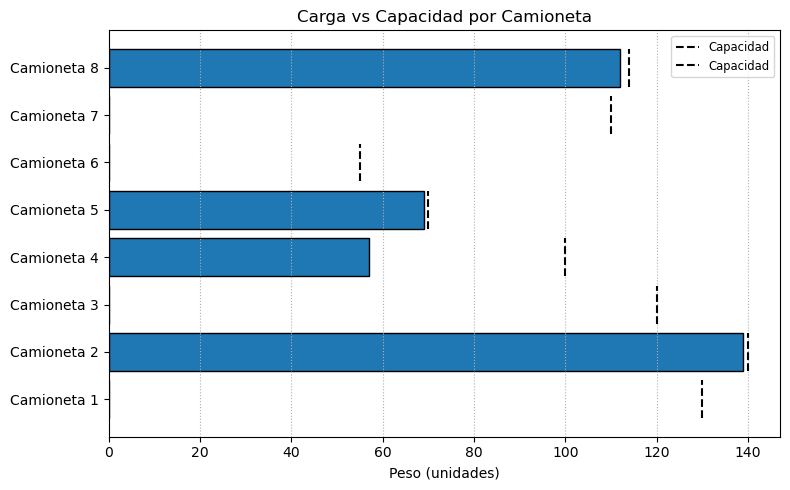

In [15]:
import matplotlib.pyplot as plt

weights = {}
capacities = {}
for v in model.V:
    # clientes atendidos por vehículo v
    visited = [
        j for j in model.C 
        if any(model.x[i, j, v].value > 0.5 for i in model.N if i != j)
    ]
    weights[v]    = sum(model.d[j] for j in visited)
    capacities[v] = model.q[v]

vehicles = list(model.V)
loaded   = [weights[v]    for v in vehicles]
caps     = [capacities[v] for v in vehicles]


y_pos = list(range(len(vehicles)))

# Grafica
fig, ax = plt.subplots(figsize=(8, 5))

ax.barh(y_pos, loaded, edgecolor='black')

# cacapacidad máxima
for idx, cap in enumerate(caps):
    ax.vlines(cap, idx-0.4, idx+0.4,
              linestyles='--', color='black',
              label='_nolegend_' if idx>0 else 'Capacidad')

# Etiquetas y leyenda
ax.set_yticks(y_pos)
ax.set_yticklabels([f'Camioneta {v}' for v in vehicles])
ax.set_xlabel('Peso (unidades)')
ax.set_title('Carga vs Capacidad por Camioneta')
ax.plot([], [], linestyle='--', color='black', label='Capacidad')
ax.legend(loc='best', fontsize='small')
ax.grid(axis='x', linestyle=':')

plt.tight_layout()
plt.show()



La grafica anterior permite ver la relación del peso máximo de capacidad que tiene cada camioneta empleada respecto al peso que cargo para poder llevar las unidades necesitadas por cada cliente que atendió. La barra azul permite ver el peso (en unidades) que repartió, mientras que la línea punteada nos indica el límite máximo que tiene cada camioneta en cuenta a capacidad. 

Todo ello nos permite ver que la solución encontrada en el modelo cumple con esa restricción, ya que vemos que en ningún caso se supera la capacidad máxima del vehículo, en todas las camionetas empleadas se puede ver que la barra azul llega a estar muy cerca de la capacidad máxima (barra punteada) como en el caso de la camioneta 2, la camioneta 5 y la camioneta 8. O incluso puede estar bastante lejos como el caso de la camioneta 4.

Pero lo más importante, es que en ningún caso la barra azul supere a la línea punteada.


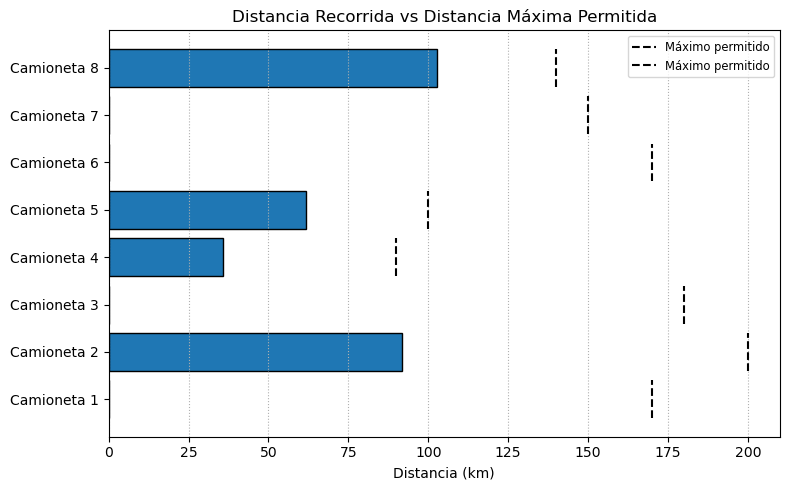

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

vehicles_df = pd.read_csv('data-caso1/vehicles.csv')
max_dist  = dict(zip(vehicles_df['VehicleID'], vehicles_df['Range']))

traveled = {}
for v in model.V:
    traveled[v] = sum(
        model.dist[i, j] * model.x[i, j, v].value
        for i in model.N for j in model.N if i != j
    )

vehicles     = list(model.V)
dist_traveled = [traveled[v] for v in vehicles]
dist_max      = [max_dist[v]  for v in vehicles]

y_pos = list(range(len(vehicles)))

# Dibujo
fig, ax = plt.subplots(figsize=(8, 5))

# Barras horizontales de distancia recorrida
ax.barh(y_pos, dist_traveled, edgecolor='black')

# Líneas punteadas de distancia máxima
for idx, cap in enumerate(dist_max):
    ax.vlines(cap, idx-0.4, idx+0.4,
              linestyles='--', color='black',
              label='_nolegend_' if idx > 0 else 'Máximo permitido')

# Etiquetas y leyenda
ax.set_yticks(y_pos)
ax.set_yticklabels([f'Camioneta {v}' for v in vehicles])
ax.set_xlabel('Distancia (km)')
ax.set_title('Distancia Recorrida vs Distancia Máxima Permitida')
ax.plot([], [], linestyle='--', color='black', label='Máximo permitido')
ax.legend(loc='best', fontsize='small')
ax.grid(axis='x', linestyle=':')

plt.tight_layout()
plt.show()


Esta grafica hace cosas muy similares a la anterior, ya que permite ver la distancia máxima que un vehículo puede recorrer dada la información que se tiene (columna rango en el csv), respecto a la distancia que termine recorriendo para llegar a cada uno de los clientes a los cuales llega. 

Nuevamente, esto permite ver si el modelo está cumpliendo con esa restricción o no; cosa que ocurre perfectamente, ya que en ningún momento la barra azul, que indica la distancia que el vehículo recorrió alcanza o sobrepasa la línea punteada, indicador del rango máximo. En este caso, a diferencia de la gráfica anterior, podemos ver que realmente queda muy lejos del límite, lo cual indica que ninguno de los vehículos quedo cerca de alcanzar el límite máximo de distancia recorrida.

# Caso 2

Se utiliza la API de OpenRouteService para generar matrices de distancias y tiempos entre un centro de distribución y una lista de clientes. Primero, se configura el cliente de OpenRouteService con una llave API válida. Luego, se cargan las coordenadas del centro de distribución y las ubicaciones de los clientes desde un archivo CSV (clients.csv). Estas ubicaciones se combinan en una lista llamada locations, que incluye las coordenadas del centro de distribución como el primer elemento, seguido de las coordenadas de los clientes. Posteriormente, se realiza una solicitud a la API para calcular las distancias (en metros) y los tiempos (en segundos) entre todas las ubicaciones, utilizando el perfil de conducción (driving-car).

Una vez obtenida la matriz de distancias y tiempos, los datos se procesan para convertir las distancias de metros a kilómetros y los tiempos de segundos a minutos. Estas matrices convertidas se almacenan en DataFrames de pandas, donde los índices y columnas representan las ubicaciones. Finalmente, las matrices se guardan en archivos CSV (generated_distances_km.csv y generated_durations_min.csv) para su uso posterior. Si ocurre algún error durante la generación de la matriz, se imprime un mensaje indicando que no se pudo completar el proceso.

In [17]:
import pandas as pd
import openrouteservice as ors

# Configuración del cliente de OpenRouteService con la llave API
client = ors.Client(key="5b3ce3597851110001cf6248685dee6e2f98402882683cd17ed2a892")

# Carga de los datos del centro de distribución y los clientes
centro_distribucion = {"Longitude": -71.71620272777695, "Latitude": 12.318460239849047}
clients = pd.read_csv("data-caso2/clients.csv")

# Creación de la lista de ubicaciones (centro de distribución y clientes)
locations = [[centro_distribucion["Longitude"], centro_distribucion["Latitude"]]]
locations.extend(clients[["Longitude", "Latitude"]].values.tolist())

# Generación de la matriz de distancias y tiempos
try:
    matrix = client.distance_matrix(
        locations=locations,
        profile='driving-car',
        sources=list(range(len(locations))),
        destinations=list(range(len(locations))),
        metrics=['distance', 'duration'],
    )
except Exception as e:
    print(f"Error al generar la matriz: {e}")
    matrix = None

# Procesamiento de la matriz de distancias y tiempos
if matrix:
    distances = matrix['distances']  # Distancias en metros
    durations = matrix['durations']  # Duraciones en segundos

    # Conversión de las distancias a kilómetros y los tiempos a minutos
    distances_km = [[dist / 1000 for dist in row] for row in distances]  # Convertir metros a kilómetros
    durations_min = [[dur / 60 for dur in row] for row in durations]  # Convertir segundos a minutos

    # Conversión de las matrices a DataFrames de pandas
    distances_df = pd.DataFrame(distances_km, index=range(len(locations)), columns=range(len(locations)))
    durations_df = pd.DataFrame(durations_min, index=range(len(locations)), columns=range(len(locations)))

    # Guardado de las matrices en archivos CSV
    distances_df.to_csv("data-caso2/generated_distances_km.csv", index=True, header=True)
    durations_df.to_csv("data-caso2/generated_durations_min.csv", index=True, header=True)

    print("Matrices de distancias (km) y tiempos (min) generadas y guardadas en archivos CSV.")
else:
    print("No se pudo generar la matriz.")

Matrices de distancias (km) y tiempos (min) generadas y guardadas en archivos CSV.


In [18]:
import pandas as pd
import json

# Carga las matrices de distancias y tiempos desde los archivos CSV
camion_distancias = pd.read_csv("data-caso2/generated_distances_km.csv", index_col=0)
camion_tiempos = pd.read_csv("data-caso2/generated_durations_min.csv", index_col=0)


camion_distancias.index = camion_distancias.index 
camion_distancias.columns = camion_distancias.columns.astype(int) 
camion_tiempos.index = camion_tiempos.index 
camion_tiempos.columns = camion_tiempos.columns.astype(int) 

# Creación de  diccionario para almacenar las distancias y tiempos en el formato deseado
distancias_tiempos = {}

for i in camion_distancias.index:
    distancias_tiempos[i] = {}
    for j in camion_distancias.columns:
        distancia = camion_distancias.loc[i, j]
        tiempo = camion_tiempos.loc[i, j]
        distancias_tiempos[i][j] = [distancia, tiempo]


distancias_tiempos_json = json.dumps(distancias_tiempos, indent=2)

with open("json-resultados-api/distancias_tiempos.json", "w") as f:
    f.write(distancias_tiempos_json)

print("distancias_tiempos.json creado con éxito.")

distancias_tiempos.json creado con éxito.


## Implementación modelo caso 2 

Se ha ampliado el modelo de optimización para incluir tanto drones como camionetas, cada uno con capacidades y características específicas. A diferencia del caso anterior, donde todos los vehículos eran tratados de manera uniforme, ahora se diferencian según su tipo. Las camionetas (4x4) tienen mayor capacidad de carga y pueden recorrer rutas más largas, mientras que los drones tienen capacidades más limitadas y están restringidos a rutas específicas. Esta diferenciación se logra mediante el uso de un parámetro tipo_vehiculo, que asigna un valor binario a cada vehículo según su tipo.

Además, se han incorporado restricciones relacionadas con ventanas de tiempo para cada cliente. Estas ventanas de tiempo aseguran que las entregas se realicen dentro de un rango horario permitido, ajustando los límites inferior y superior para mayor flexibilidad. Esto se implementa mediante funciones que procesan las ventanas de tiempo y las convierten en minutos, y luego se aplican restricciones para garantizar que los tiempos de llegada de los vehículos cumplan con estos límites.



In [19]:
from pyomo.environ import (
    ConcreteModel, Set, Param, Var, Binary, NonNegativeReals,
    Objective, Constraint, minimize, SolverFactory
)
import pandas as pd

# Cargar datos de clientes y vehículos desde archivos CSV
clients = pd.read_csv("data-caso2/clients.csv")
vehicles = pd.read_csv("data-caso2/vehicles.csv")

# Crear listas de IDs de clientes y vehículos
clientes = clients["ClientID"].tolist()
vehiculos = vehicles["VehicleID"].tolist()
nodos = [0] + clientes  # Nodo 0 es el depósito

# Crear diccionarios con la demanda de los clientes y la capacidad de los vehículos
demanda = dict(zip(clients["ClientID"], clients["Demand"]))
capacidad = dict(zip(vehicles["VehicleID"], vehicles["Capacity"]))

# Asignar tipo de vehículo: 1 = 4x4, 0 = Dron
tipo_vehiculo = dict(zip(vehicles["VehicleID"], (1 if t.lower() == "4x4" else 0 for t in vehicles["Type"])))

# Función para parsear las ventanas de tiempo y ajustarlas
def parse_time_window(time_window):
    start, end = time_window.split('-')
    h1, m1 = map(int, start.split(':'))
    h2, m2 = map(int, end.split(':'))
    # Convertir a minutos 
    start_minutes = max(0, h1 * 60 + m1)  
    end_minutes = h2 * 60 + m2             
    return start_minutes, end_minutes

# Crear un diccionario con las ventanas de tiempo ajustadas para cada cliente
time_windows = {row.ClientID: parse_time_window(row.TimeWindow) for _, row in clients.iterrows()}

# Construir matrices de distancia y tiempo para cada par de nodos y vehículo
distancias, tiempos = {}, {}
for i in nodos:
    for j in nodos:
        if i != j:
            for v in vehiculos:
                try:
                    if tipo_vehiculo[v] == 1:  # Camioneta
                        dist, tiempo_viaje, *_ = distancias_tiempos[i][j]
                    else:  # Dron
                        dist, tiempo_viaje, *_ = graphdron[i][j]
                except KeyError:
                    dist, tiempo_viaje = 999, 0
                distancias[(i, j, v)] = dist
                tiempos[(i, j, v)] = tiempo_viaje

# Crear el modelo de optimización con Pyomo
model = ConcreteModel()

# Definir los conjuntos de nodos, clientes y vehículos
model.N = Set(initialize=nodos)
model.C = Set(initialize=clientes)
model.V = Set(initialize=vehiculos)

# Definir los parámetros: demanda, capacidad y tipo de vehículo
model.d = Param(model.C, initialize=demanda)
model.q = Param(model.V, initialize=capacidad)
model.delta = Param(model.V, initialize=tipo_vehiculo)

# Definir los costos fijos y variables asociados
model.Pf = Param(initialize=15000)
model.Cm = Param(initialize=700)
model.Ce = Param(initialize=0)
model.Ft = Param(initialize=5000)
model.Cv = Param(initialize=0)

# Definir los parámetros de distancia y tiempo entre nodos
model.dist = Param(model.N, model.N, model.V, initialize=distancias, default=1e6)
model.t = Param(model.N, model.N, model.V, initialize=tiempos, default=0)

# Definir las variables de decisión: ruta, carga y tiempo de llegada
model.x = Var(model.N, model.N, model.V, domain=Binary)  # Ruta (i,j) con vehículo v
model.u = Var(model.C, model.V, domain=NonNegativeReals)  # Carga acumulada en nodo i con vehículo v
model.t_arrival = Var(model.C, model.V, domain=NonNegativeReals)  # Tiempo de llegada a cada cliente

# Definir la función objetivo: minimizar el costo total
def obj_cost(m):
    return sum(
        (m.Pf * m.dist[i, j, v] * m.delta[v] + m.Cm + m.delta[v]*m.Ce + m.Ft + m.Cv * m.t[i, j, v]) * m.x[i, j, v]
        for i in m.N for j in m.N for v in m.V if i != j
    )
model.obj = Objective(rule=obj_cost, sense=minimize)

# Restricción: cada cliente debe ser visitado exactamente una vez
model.cliente_una_vez = Constraint(
    model.C,
    rule=lambda m, j: sum(m.x[i, j, v] for i in m.N for v in m.V if i != j) == 1
)

# Restricción: cada cliente debe tener una salida
model.cliente_salida = Constraint(
    model.C,
    rule=lambda m, j: sum(m.x[j, k, v] for k in m.N for v in m.V if j != k) == 1
)

# Restricción: conservación de flujo en cada cliente para cada vehículo
model.flujo = Constraint(
    model.C, model.V,
    rule=lambda m, j, v: sum(m.x[i, j, v] for i in m.N if i != j) - sum(m.x[j, k, v] for k in m.N if k != j) == 0
)

# Restricción: salida y entrada del depósito para cada vehículo
model.salida_dep = Constraint(
    model.V,
    rule=lambda m, v: sum(m.x[0, j, v] for j in m.C) <= 1
)
model.entrada_dep = Constraint(
    model.V,
    rule=lambda m, v: sum(m.x[i, 0, v] for i in m.C) <= 1
)



# Restricción MTZ para prevenir subtours y controlar el flujo
def mtz_rule(m, i, j, v):
    if i != j:
        return m.u[i, v] + m.d[j] - m.u[j, v] <= m.q[v] * (1 - m.x[i, j, v])
    else:
        return Constraint.Skip
model.mtz = Constraint(model.C, model.C, model.V, rule=mtz_rule)

# Restricción para asegurar que las cargas se mantengan dentro de los límites
model.lim_u = Constraint(
    model.C, model.V,
    rule=lambda m, i, v: (m.d[i], m.u[i, v], m.q[v])
)

# Restricción de capacidad total por vehículo
model.cap_total = Constraint(
    model.V,
    rule=lambda m, v: sum(m.d[j] * m.x[i, j, v] for i in m.N for j in m.C if i != j) <= m.q[v]
)

# Restricción para las ventanas de tiempo de cada cliente
def time_window_lower_rule(m, j, v):
    return m.t_arrival[j, v] >= time_windows[j][0]
model.time_window_lower = Constraint(model.C, model.V, rule=time_window_lower_rule)

def time_window_upper_rule(m, j, v):
    return m.t_arrival[j, v] <= time_windows[j][1]
model.time_window_upper = Constraint(model.C, model.V, rule=time_window_upper_rule)


def arrival_time_rule(m, i, j, v):
    if i != j and i in m.C and j in m.C:
        return m.t_arrival[j, v] >= m.t_arrival[i, v] + m.t[i, j, v] - (1 - m.x[i, j, v]) * 1e6
    return Constraint.Skip
model.arrival_time = Constraint(model.C, model.C, model.V, rule=arrival_time_rule)

# Resolver el modelo con el solver GLPK
solver = SolverFactory("glpk")
solver.options["tmlim"] = 30  # Límite de tiempo
solver.options["mipgap"] = 0.05  # Tolerancia de gap
results = solver.solve(model, tee=True)

# Mostrar los resultados del solver
print("Status:     ", results.solver.status)
print("Termination:", results.solver.termination_condition)
print("Obj. value: ", model.obj())

# Función para formatear los nodos
def formatear_nodo(nodo):
    if nodo == 0:
        return "ÇD"
    else:
        return f"ÇOM{int(nodo):02d}"

# Función para convertir minutos a horas en formato HH:MM
def convertir_a_horas(minutos):
    horas = int(minutos // 60)  
    mins = int(minutos % 60)   
    return f"{horas:02}:{mins:02}"  # Formatear con dos dígitos

# Imprimir las rutas asignadas por vehículo y los tiempos de llegada
print("\nRUTAS ASIGNADAS POR VEHÍCULO:")
for v in model.V:
    rutas, actual, visitados = [], 0, set()
    demanda_total = 0  # Acumular demanda total atendida
    tiempo_total = 0  # Acumular tiempo total
    while True:
        nxt = next((j for j in model.N if j != actual and model.x[actual, j, v].value > 0.5), None)
        if nxt is None or nxt in visitados:
            break
        rutas.append((actual, nxt))
        if nxt != 0:  # Excluir el nodo 0 (depósito) de la demanda
            demanda_total += demanda[nxt]
        visitados.add(nxt)
        actual = nxt

    # Imprimir la ruta en el nuevo formato
    print(f"\nVehículo {v} (Tipo: {'4x4' if tipo_vehiculo[v] else 'Dron'}):")
    if not rutas:
        print(" Ruta: No asignado")
        continue

    print(" Ruta:")
    for i, j in rutas:
        if j in model.C: 
            llegada = model.t_arrival[j, v].value
            llegada_horas = convertir_a_horas(llegada)  # Convertir minutos a horas
            print(f"  {formatear_nodo(i)} -> {formatear_nodo(j)}")
            print(f"    Llegada al nodo {formatear_nodo(j)}: {llegada_horas} horas")
            tiempo_total = llegada  # Actualizar el tiempo total con el tiempo de llegada al último nodo
        else:
            print(f"  {formatear_nodo(i)} -> {formatear_nodo(j)}")

    print(f" Tiempo total: {tiempo_total:.2f} minutos")
    print(f" Demanda total atendida: {demanda_total}")

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --tmlim 30 --mipgap 0.05 --write C:\Users\57314\AppData\Local\Temp\tmpvsqf9hts.glpk.raw
 --wglp C:\Users\57314\AppData\Local\Temp\tmp6qw366m1.glpk.glp --cpxlp C:\Users\57314\AppData\Local\Temp\tmp3zkm6171.pyomo.lp
Reading problem data from 'C:\Users\57314\AppData\Local\Temp\tmp3zkm6171.pyomo.lp'...
C:\Users\57314\AppData\Local\Temp\tmp3zkm6171.pyomo.lp:11831: warning: lower bound of variable 'x2' redefined
C:\Users\57314\AppData\Local\Temp\tmp3zkm6171.pyomo.lp:11831: warning: upper bound of variable 'x2' redefined
1337 rows, 714 columns, 6466 non-zeros
630 integer variables, all of which are binary
12461 lines were read
Writing problem data to 'C:\Users\57314\AppData\Local\Temp\tmp6qw366m1.glpk.glp'...
10529 lines were written
GLPK Integer Optimizer 5.0
1337 rows, 714 columns, 6466 non-zeros
630 integer variables, all of which are binary
Preprocessing...
79 constraint coefficient(s) were reduced
680 rows, 413 c

In [20]:
# Imprimir las rutas asignadas por vehículo, los tiempos de llegada y las distancias recorridas
print("\nRUTAS ASIGNADAS POR VEHÍCULO:")
for v in model.V:
    rutas, actual, visitados = [], 0, set()
    demanda_total = 0  # Acumular demanda total atendida
    tiempo_total = 0  # Acumular tiempo total
    distancia_total = 0  # Acumular distancia total recorrida
    while True:
        nxt = next((j for j in model.N if j != actual and model.x[actual, j, v].value > 0.5), None)
        if nxt is None or nxt in visitados:
            break
        rutas.append((actual, nxt))
        distancia_total += model.dist[actual, nxt, v]  # Sumar la distancia recorrida
        if nxt in model.C:
            demanda_total += demanda[nxt]  # Acumular la demanda atendida
        visitados.add(nxt)
        actual = nxt

    # Incluir la distancia de regreso al depósito
    if actual != 0:
        rutas.append((actual, 0))
        distancia_total += model.dist[actual, 0, v]  # Sumar la distancia de regreso al depósito

    # Imprimir la ruta en el nuevo formato
    print(f"\nVehículo {v} (Tipo: {'4x4' if tipo_vehiculo[v] else 'Dron'}):")
    if not rutas:
        print(" Ruta: No asignado")
        continue

    print(" Ruta:")
    for i, j in rutas:
        distancia = model.dist[i, j, v]  # Obtener la distancia entre el nodo actual y el siguiente
        if j in model.C: 
            llegada = model.t_arrival[j, v].value
            llegada_horas = convertir_a_horas(llegada)  # Convertir minutos a horas
            print(f"  {formatear_nodo(i)} -> {formatear_nodo(j)}")
            print(f"    Distancia al nodo {formatear_nodo(j)}: {distancia:.2f} km")
            print(f"    Llegada al nodo {formatear_nodo(j)}: {llegada_horas} horas")
            tiempo_total = llegada  # Actualizar el tiempo total con el tiempo de llegada al último nodo
        else:
            print(f"  {formatear_nodo(i)} -> {formatear_nodo(j)}")
            print(f"    Distancia al nodo {formatear_nodo(j)}: {distancia:.2f} km")

    print(f" Distancia total recorrida (incluyendo retorno al depósito): {distancia_total:.2f} km")
    print(f" Tiempo total: {tiempo_total:.2f} minutos")
    print(f" Demanda total atendida: {demanda_total}")


RUTAS ASIGNADAS POR VEHÍCULO:

Vehículo 1 (Tipo: 4x4):
 Ruta:
  ÇD -> ÇOM11
    Distancia al nodo ÇOM11: 5.16 km
    Llegada al nodo ÇOM11: 08:30 horas
  ÇOM11 -> ÇOM03
    Distancia al nodo ÇOM03: 2.33 km
    Llegada al nodo ÇOM03: 10:15 horas
  ÇOM03 -> ÇOM04
    Distancia al nodo ÇOM04: 4.72 km
    Llegada al nodo ÇOM04: 13:00 horas
  ÇOM04 -> ÇOM01
    Distancia al nodo ÇOM01: 4.30 km
    Llegada al nodo ÇOM01: 13:20 horas
  ÇOM01 -> ÇOM12
    Distancia al nodo ÇOM12: 5.71 km
    Llegada al nodo ÇOM12: 13:35 horas
  ÇOM12 -> ÇOM10
    Distancia al nodo ÇOM10: 4.13 km
    Llegada al nodo ÇOM10: 14:30 horas
  ÇOM10 -> ÇOM05
    Distancia al nodo ÇOM05: 5.83 km
    Llegada al nodo ÇOM05: 14:55 horas
  ÇOM05 -> ÇOM14
    Distancia al nodo ÇOM14: 1.40 km
    Llegada al nodo ÇOM14: 15:00 horas
  ÇOM14 -> ÇD
    Distancia al nodo ÇD: 6.46 km
 Distancia total recorrida (incluyendo retorno al depósito): 40.04 km
 Tiempo total: 900.00 minutos
 Demanda total atendida: 136.0

Vehículo 2 (Tipo

## Gráficos y análisis

## Mapa de rutas por vehículo individual


MAPA DE RUTAS POR VEHÍCULO INDIVIDUAL


C:\Users\57314\AppData\Local\Temp\ipykernel_5712\1620819687.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', len(model.V))


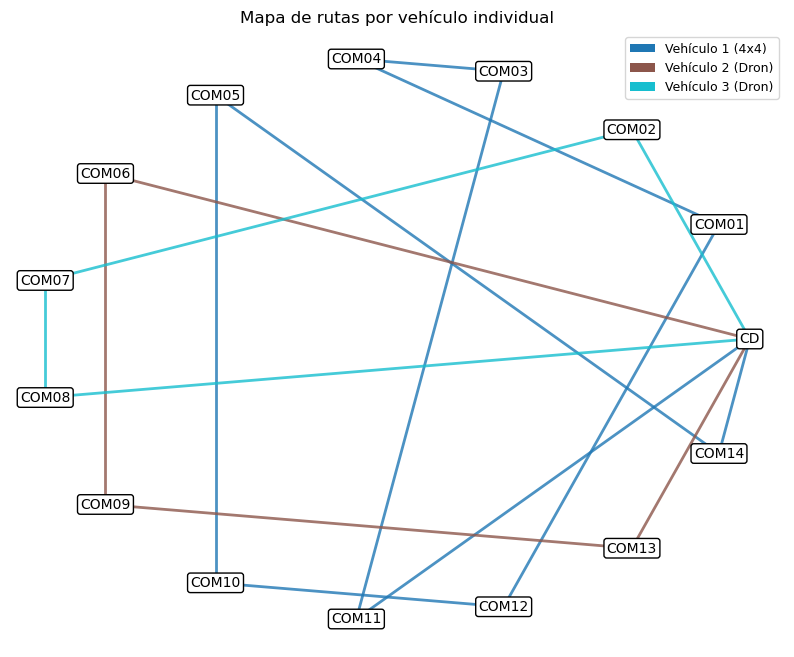

In [21]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import matplotlib.cm as cm

print("\nMAPA DE RUTAS POR VEHÍCULO INDIVIDUAL")

# Posiciones circulares para los nodos
plt.figure(figsize=(10, 8))
positions = {n: (np.cos(2*np.pi*i/len(nodos)), np.sin(2*np.pi*i/len(nodos))) for i, n in enumerate(nodos)}
labels = {0: 'CD', **{c: f'COM{str(c).zfill(2)}' for c in clientes}}

color_map = cm.get_cmap('tab10', len(model.V))  
vehiculo_colores = {v: color_map(i) for i, v in enumerate(model.V)}


for v in model.V:
    actual = 0
    visitados = set()
    while True:
        nxt = next((j for j in model.N if j != actual and model.x[actual, j, v].value > 0.5), None)
        if nxt is None or nxt in visitados:
            break
        x1, y1 = positions[actual]
        x2, y2 = positions[nxt]
        plt.plot([x1, x2], [y1, y2], color=vehiculo_colores[v], linewidth=2, alpha=0.8)
        visitados.add(nxt)
        actual = nxt

# Etiquetas de nodos
for n, (x, y) in positions.items():
    plt.text(x, y, labels[n], ha='center', va='center', fontsize=10,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))

# Leyenda: nombre del vehículo y tipo
legend_elements = []
for v in model.V:
    tipo = 'Dron' if tipo_vehiculo[v] == 0 else '4x4'
    legend_elements.append(Patch(facecolor=vehiculo_colores[v], label=f'Vehículo {v} ({tipo})'))

plt.title("Mapa de rutas por vehículo individual")
plt.axis('off')
plt.legend(handles=legend_elements, loc='upper right', fontsize=9)
plt.show()


El mapa de rutas muestra las conexiones entre el centro de distribución (CD) y las clientes (COMXX) asignadas a cada vehículo. Cada ruta está representada por líneas de colores que corresponden a un vehículo específico, diferenciando entre vehículos terrestres y drones. En general, se observa que los vehículos terrestres (líneas azules) cubren rutas más extensas y conectan múltiples clientes, mientras que los drones (líneas marrones y celestes) realizan entregas más específicas y limitadas a ciertas clientes. Esto refleja una asignación eficiente basada en las capacidades y restricciones de cada tipo de vehículo.

Se puede observar los caminos reales en una mapa a continuación:


In [22]:
import folium
from folium import Element

# Crear un mapa centrado en la ubicación promedio de los clientes
latitudes = clients["Latitude"].tolist()
longitudes = clients["Longitude"].tolist()
centro_lat = sum(latitudes) / len(latitudes)
centro_lon = sum(longitudes) / len(longitudes)

m = folium.Map(location=[centro_lat, centro_lon], zoom_start=13)

# Diccionario con coordenadas
coords = {row.ClientID: (row.Latitude, row.Longitude) for _, row in clients.iterrows()}
coords[0] = (centro_lat, centro_lon)  # Depósito

# Colores distintos por vehículo
colores = ['red', 'blue', 'pink', 'purple', 'orange', 'darkred', 'cadetblue', 'black']

# Dibujar rutas de vehículos
tipos_vehiculo = ['4x4', 'drone', 'drone']  
for idx, v in enumerate(model.V):
    rutas, actual, visitados = [], 0, set()
    while True:
        nxt = next((j for j in model.N if j != actual and model.x[actual, j, v].value > 0.5), None)
        if nxt is None or nxt in visitados:
            break
        rutas.append((actual, nxt))
        visitados.add(nxt)
        actual = nxt

    color = colores[idx % len(colores)]
    tipo_vehiculo = tipos_vehiculo[idx % len(tipos_vehiculo)]  # selección de  tipo de vehículo
    for i, j in rutas:
        coord_i = coords[i]
        coord_j = coords[j]

        folium.Marker(
            coord_j,
            tooltip=f"{formatear_nodo(j)} - {tipo_vehiculo}",
            icon=folium.Icon(color=color)
        ).add_to(m)

        folium.PolyLine([coord_i, coord_j], color=color, weight=3, opacity=0.7).add_to(m)


folium.Marker(
    location=[centro_lat, centro_lon],
    tooltip="Depósito (Nodo 0)",
    icon=folium.Icon(color='gray', icon='home', prefix='fa')
).add_to(m)


leyenda_html = '''
<div style="
    position: fixed; 
    bottom: 50px; left: 50px; width: 220px; height: auto; 
    background-color: white; z-index:9999; font-size:14px; 
    border:2px solid grey; border-radius:8px; padding: 10px;
    box-shadow: 2px 2px 6px rgba(0,0,0,0.3);
">
<b>Leyenda de vehículos</b><br>
<i style="background:gray;width:10px;height:10px;display:inline-block;margin-right:5px;"></i> Depósito (Nodo 0)<br>
''' + ''.join([
    f'<i style="background:{colores[i % len(colores)]};width:10px;height:10px;display:inline-block;margin-right:5px;"></i> Vehicle {v} ({tipos_vehiculo[i % len(tipos_vehiculo)]})<br>'
    for i, v in enumerate(model.V)
]) + '</div>'

m.get_root().html.add_child(Element(leyenda_html))

# Mostrar el mapa
m


### Gráfico de Gantt

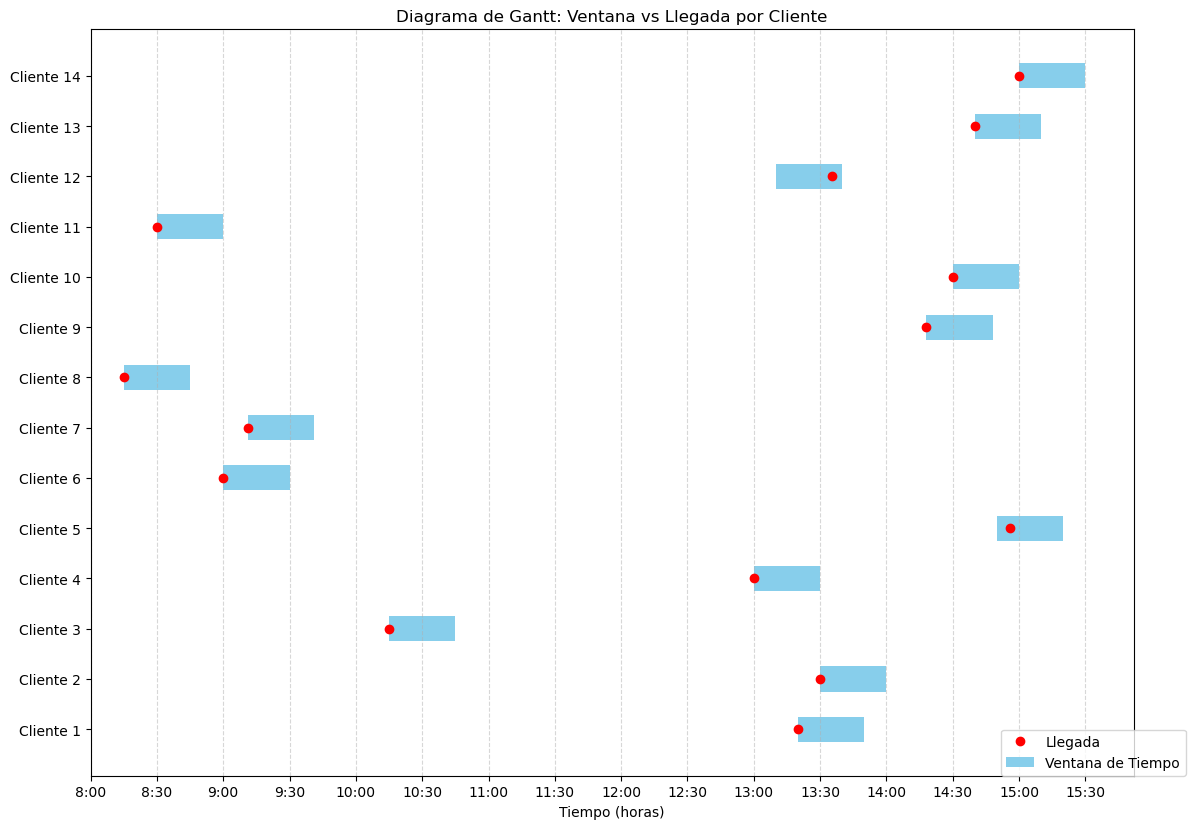

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

gantt_data = []

for v in model.V:
    for c in model.C:
        if model.x[0, c, v].value or any(model.x[i, c, v].value > 0.5 for i in model.N if i != c):
            if model.t_arrival[c, v].value is not None:
                arrival_time = model.t_arrival[c, v].value
                start, end = time_windows[c]
                gantt_data.append({
                    'Cliente': c,  
                    'Vehículo': v,
                    'Inicio_VT': start / 60,  
                    'Fin_VT': end / 60,  
                    'Llegada': arrival_time / 60  
                })

gantt_data = sorted(gantt_data, key=lambda x: x['Cliente'])

fig, ax = plt.subplots(figsize=(12, len(gantt_data) * 0.6))  

for i, row in enumerate(gantt_data):
    y_pos = i
    ax.barh(y=y_pos, width=row['Fin_VT'] - row['Inicio_VT'], left=row['Inicio_VT'], height=0.5, color='skyblue', label='Ventana de Tiempo' if i == 0 else "")
    ax.plot(row['Llegada'], y_pos, 'ro', label='Llegada' if i == 0 else "")


ax.set_yticks(range(len(gantt_data)))
ax.set_yticklabels([f'Cliente {row["Cliente"]}' for row in gantt_data])  
ax.set_xlabel('Tiempo (horas)')  
ax.set_title('Diagrama de Gantt: Ventana vs Llegada por Cliente')
ax.set_xticks(np.arange(int(min(row['Inicio_VT'] for row in gantt_data)), int(max(row['Fin_VT'] for row in gantt_data)) + 1, 1/2))  
ax.set_xticklabels([f'{int(i)}:{int((i % 1) * 60):02d}' for i in ax.get_xticks()])  


ax.legend(loc='lower right', bbox_to_anchor=(1.05,0 ), borderaxespad=0.)
plt.tight_layout() 
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()


El diagrama de Gantt muestra el cumplimiento de las ventanas de tiempo para cada cliente, representadas por barras azules, y los tiempos de llegada de los vehículos, marcados con puntos rojos. En general, se observa que la mayoría de los clientes son atendidos dentro de sus ventanas de tiempo, lo que indica un buen desempeño del modelo de optimización. Sin embargo, algunos puntos rojos cercanos a los límites de las ventanas sugieren que ciertos clientes fueron atendidos justo al inicio o al final de sus intervalos permitidos, lo que podría ser un área de mejora para reducir riesgos de incumplimiento.

## ArchivoS de verificación

Se generó un archivo llamado caso2verificacion.csv, ubicado en la carpeta verification, que contiene una tabla resumen de las rutas realizadas por cada vehículo. En dicho archivo se registra para cada movimiento entre nodos el tipo de vehículo, el nodo de origen y destino, el horario de llegada, la ventana de tiempo correspondiente, y se verifica si se cumplió con dicha ventana. Además, se calculó la demanda acumulada hasta ese punto y se comprobó si se mantuvo dentro de la capacidad máxima del vehículo. Esta verificación permite validar el cumplimiento de las restricciones operativas del modelo.

In [26]:
import os
import csv
import pandas as pd

# Cargar los datos de los vehículos desde vehicles.csv
vehicles = pd.read_csv("data-caso2/vehicles.csv")

# Crear un diccionario que asocia cada VehicleID con su tipo
tipo_vehiculo = dict(zip(vehicles["VehicleID"], vehicles["Type"]))

# Crear un diccionario que asocia cada VehicleID con su rango máximo
rango_vehiculo = dict(zip(vehicles["VehicleID"], vehicles["Range"]))

os.makedirs("verification", exist_ok=True)

# Lista para almacenar las filas del CSV
verificacion_data = []

for v in model.V:
    actual = 0
    carga = 0
    distancia_total = 0
    visitados = set()
    
    while True:
        nxt = next((j for j in model.N if j != actual and model.x[actual, j, v].value > 0.5), None)
        if nxt is None or nxt in visitados:
            break

        if nxt in model.C:
            llegada_min = model.t_arrival[nxt, v].value
            llegada_hora = convertir_a_horas(llegada_min)

            ventana_inicio, ventana_fin = time_windows[nxt]
            dentro_ventana = ventana_inicio <= llegada_min <= ventana_fin

            carga += demanda[nxt]
            dentro_capacidad = carga <= capacidad[v]

            # Calcular la distancia entre el nodo actual y el siguiente
            distancia = model.dist[actual, nxt, v]
            distancia_total += distancia

            # Obtener el rango máximo del vehículo
            rango_maximo = rango_vehiculo[v]

            # Verificar si la distancia total está dentro del rango del vehículo
            dentro_rango = distancia_total <= rango_maximo

            # Agregar los datos a la lista
            verificacion_data.append([
                v,
                tipo_vehiculo[v],
                formatear_nodo(actual),
                formatear_nodo(nxt),
                llegada_hora,
                f"{convertir_a_horas(ventana_inicio)} - {convertir_a_horas(ventana_fin)}",
                "Sí" if dentro_ventana else "No",
                carga,
                capacidad[v],
                "Sí" if dentro_capacidad else "No",
                f"{distancia_total:.2f} km",
                rango_maximo,
                "Sí" if dentro_rango else "No"
            ])

            visitados.add(nxt)
        actual = nxt

# Guardar el CSV
with open("verification/verificacion_case2.csv", mode="w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow([
        "Vehículo", "Tipo", "Nodo Origen", "Nodo Destino", "Llegada (HH:MM)",
        "Ventana (Inicio - Fin)", "Dentro de ventana",
        "Demanda acumulada", "Capacidad vehículo", "Dentro de capacidad",
        "Distancia total acumulada (km)", "Rango máximo (km)", "Dentro del rango"
    ])
    writer.writerows(verificacion_data)

print("Archivo 'caso2verificacion.csv' guardado correctamente en la carpeta 'verification'.")

Archivo 'caso2verificacion.csv' guardado correctamente en la carpeta 'verification'.


**Archivo de verificación generado**

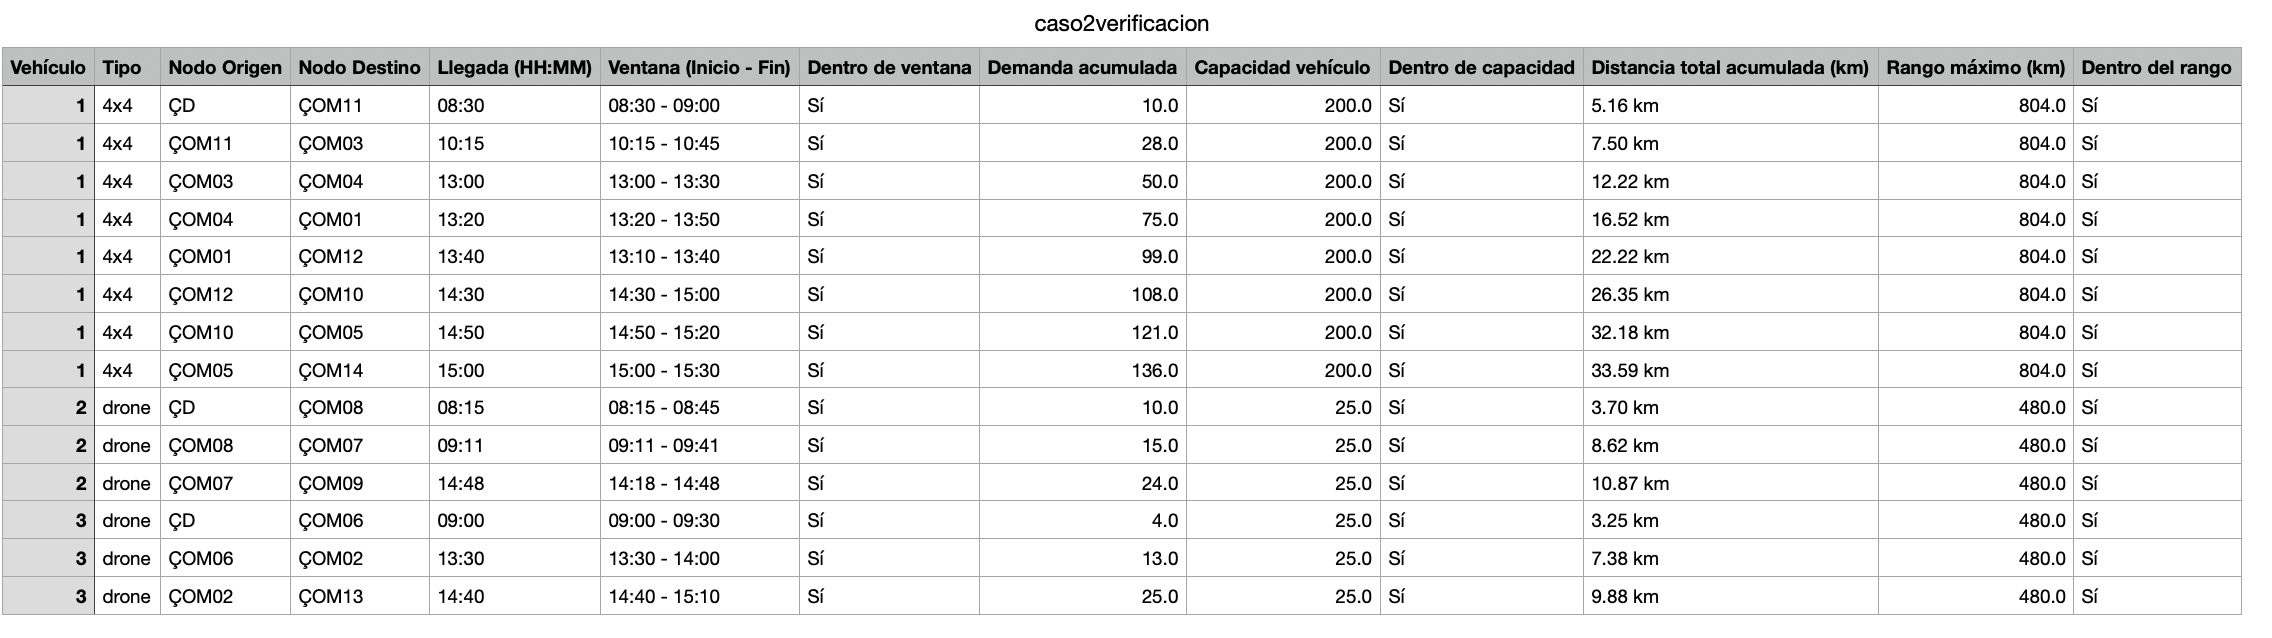

La tabla de verificación generada muestra un análisis detallado del desempeño de los vehículos en términos de cumplimiento de restricciones operativas, como ventanas de tiempo, capacidad de carga y rango máximo permitido. En el caso de los vehículos tipo "4x4", se observa que todos los nodos visitados están dentro de las ventanas de tiempo especificadas, lo que indica una planificación adecuada de las rutas. Además, la demanda acumulada en cada punto de entrega nunca excede la capacidad máxima del vehículo, lo que confirma que la asignación de carga fue correctamente diseñada. La distancia total acumulada para el vehículo "4x4" más utilizado (Vehículo 1) es de 33.59 km, lo cual está muy por debajo de su rango máximo de 804 km, asegurando que el vehículo puede completar su recorrido sin problemas relacionados con el alcance.

En el caso de los drones, representados como vehículos tipo "drone", también se cumple con las restricciones de ventanas de tiempo y capacidad de carga. Sin embargo, los drones tienen un rango máximo significativamente menor (480 km), lo que limita su capacidad para realizar recorridos más largos. A pesar de esta limitación, los drones cumplen con sus rutas asignadas, manteniendo la distancia total acumulada dentro del rango permitido. Por ejemplo, el Vehículo 2 tiene una distancia total acumulada de 10.87 km, lo que está muy por debajo de su rango máximo, lo que demuestra que los drones son efectivos para cubrir distancias cortas y realizar entregas en ubicaciones cercanas.

En general, los resultados reflejan una planificación eficiente de las rutas y una asignación adecuada de los vehículos según sus capacidades y limitaciones. Los vehículos "4x4" son utilizados para cubrir rutas más largas y manejar mayores demandas de carga, mientras que los drones se emplean para entregas más específicas y cercanas. Esto sugiere que el modelo de optimización está funcionando correctamente, asignando los recursos de manera eficiente y asegurando que se cumplan todas las restricciones operativas. 

**Archivo de verificación - verificacion_caso2.csv**

Asimismo, se creó el archivo de verificación solicitado en el enunciado:

In [27]:
import os
import csv

# Crear la carpeta de verificación si no existe
os.makedirs("verification", exist_ok=True)
tipo_vehiculo = dict(zip(vehicles["VehicleID"], (1 if t.lower() == "4x4" else 0 for t in vehicles["Type"])))


# Lista para almacenar las filas del archivo de verificación
verificacion_data = []

for v in model.V:
    rutas, actual, visitados = [], 0, set()
    demanda_total = 0  # Acumular demanda total atendida
    tiempo_total = 0  # Acumular tiempo total
    distancia_total = 0  # Acumular distancia total recorrida
    ruta_secuencia = ["CD"]  # Iniciar la ruta desde el depósito
    demandas = []
    tiempos_llegada = []

    while True:
        nxt = next((j for j in model.N if j != actual and model.x[actual, j, v].value > 0.5), None)
        if nxt is None or nxt in visitados:
            break
        rutas.append((actual, nxt))
        distancia_total += model.dist[actual, nxt, v]  # Sumar la distancia recorrida
        if nxt in model.C:
            demanda_total += demanda[nxt]  # Acumular la demanda atendida
            llegada = model.t_arrival[nxt, v].value
            llegada_horas = convertir_a_horas(llegada)  # Convertir minutos a horas
            tiempos_llegada.append(llegada_horas)
            demandas.append(demanda[nxt])
        ruta_secuencia.append(formatear_nodo(nxt))
        visitados.add(nxt)
        actual = nxt

    # Incluir la distancia de regreso al depósito
    if actual != 0:
        rutas.append((actual, 0))
        distancia_total += model.dist[actual, 0, v]  # Sumar la distancia de regreso al depósito
        ruta_secuencia.append("CD")

    if not rutas:
        continue


    for i, j in rutas:
        distancia = model.dist[i, j, v]  # Obtener la distancia entre el nodo actual y el siguiente
        if j in model.C: 
            llegada = model.t_arrival[j, v].value
            llegada_horas = convertir_a_horas(llegada)  # Convertir minutos a horas
            tiempo_total = llegada  # Actualizar el tiempo total con el tiempo de llegada al último nodo
        else:
            print(" ")


    # Agregar los datos finales al archivo de verificación
    if ruta_secuencia:
        if tipo_vehiculo[v] == 0:
            tipo_vehiculo[v] = "Dron"
        else: 
            tipo_vehiculo[v] = "4x4"
        verificacion_data.append([
            v,
            tipo_vehiculo[v],
            capacidad[v],  # Carga inicial del vehículo
            " - ".join(ruta_secuencia),  # Secuencia de la ruta
            len(ruta_secuencia) - 2,  # Clientes servidos (excluyendo depósito)
            " - ".join(map(str, demandas)),  # Demanda satisfecha por cliente
            " - ".join(tiempos_llegada),  # Tiempos de llegada
            f"{distancia_total:.2f} km",  # Distancia total
            f"{tiempo_total} min",  # Tiempo total en horas
            f"{distancia_total * 15000:.2f}"  
        ])

# Guardar el archivo CSV
with open("verification/verificacion_caso2.csv", mode="w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow([
        "VehicleId", "VehicleType", "InitialLoad", "RouteSequence", "ClientsServed",
        "DemandSatisfied", "ArrivalTimes", "TotalDistance", "TotalTime", "Cost"
    ])
    writer.writerows(verificacion_data)

print("Archivo 'verificacion_caso2.csv' guardado correctamente en la carpeta 'verification'.")

 
 
 
Archivo 'verificacion_caso2.csv' guardado correctamente en la carpeta 'verification'.


## Conclusión

En conclusión, el modelo desarrollado para la asignación de rutas y vehículos demuestra un alto nivel de eficiencia y cumplimiento de las restricciones operativas. Los resultados reflejan una asignación adecuada de vehículos terrestres y drones según sus capacidades y limitaciones, optimizando las rutas para satisfacer la demanda de los clientes dentro de las ventanas de tiempo establecidas.

El análisis de los diagramas de Gantt confirma que los tiempos de llegada cumplen mayoritariamente con las restricciones temporales, mientras que el mapa de rutas visualiza claramente la distribución de las entregas entre los vehículos. En general, el enfoque utilizado logra resolver el problema logístico planteado de manera efectiva, garantizando la optimización de recursos y el cumplimiento de las restricciones.

# Caso 3


Similar al caso 2, se utiliza la API de OpenRouteService para generar matrices de distancias y tiempos entre un centro de distribución y una lista de clientes. Primero, se configura el cliente de OpenRouteService con una llave API válida. Luego, se cargan las coordenadas del centro de distribución y las ubicaciones de los clientes desde un archivo CSV (clients.csv). Estas ubicaciones se combinan en una lista llamada locations, que incluye las coordenadas del centro de distribución como el primer elemento, seguido de las coordenadas de los clientes. Posteriormente, se realiza una solicitud a la API para calcular las distancias (en metros) y los tiempos (en segundos) entre todas las ubicaciones, utilizando el perfil de conducción (driving-car).

Una vez obtenida la matriz de distancias y tiempos, los datos se procesan para convertir las distancias de metros a kilómetros y los tiempos de segundos a minutos. Estas matrices convertidas se almacenan en DataFrames de pandas, donde los índices y columnas representan las ubicaciones. Finalmente, las matrices se guardan en archivos CSV (generated_distances_km.csv y generated_durations_min.csv) para su uso posterior. Si ocurre algún error durante la generación de la matriz, se imprime un mensaje indicando que no se pudo completar el proceso.

In [1]:

import math
import pandas as pd

def haversine(coord1, coord2):
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    R = 6371.0  # Radio de la Tierra en km
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    a = math.sin(delta_phi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

# === Cargar datos ===
clients = pd.read_csv("data-caso3/clients.csv")
depots = pd.read_csv("data-caso3/depots.csv")
vehicles = pd.read_csv("data-caso3/vehicles.csv")

# === Crear diccionario de nodos (LocationID -> (lon, lat)) ===
nodes = {}

# Agregar depósitos con su LocationID real
for _, row in depots.iterrows():
    loc_id = int(row["LocationID"])
    nodes[loc_id] = (row["Longitude"], row["Latitude"])

# Agregar clientes
for _, row in clients.iterrows():
    loc_id = int(row["LocationID"])
    nodes[loc_id] = (row["Longitude"], row["Latitude"])

# === Filtrar drones y obtener velocidades ===
drones = vehicles[vehicles["Type"].str.lower() == "drone"]

# Asegurar velocidades válidas
drone_speeds = [
    float(speed) for speed in drones["Speed"] if speed != "N/A"
]
if drone_speeds:
    avg_speed_km_min = sum(drone_speeds) / (60.0 * len(drone_speeds))  # km/min
else:
    avg_speed_km_min = None

# === Crear grafo de distancias y tiempos para drones ===
graphdron3 = {}

for i, coord_i in nodes.items():
    graphdron3[i] = {}
    for j, coord_j in nodes.items():
        if i == j:
            graphdron3[i][j] = (999, 999)
        else:
            dist_km = haversine(coord_i, coord_j)
            if avg_speed_km_min and avg_speed_km_min > 0:
                dur_min = dist_km / avg_speed_km_min
                graphdron3[i][j] = (round(dist_km, 3), round(dur_min, 3))
            else:
                graphdron3[i][j] = (999, 999)


In [2]:

import pandas as pd
import openrouteservice as ors
import json

# === Configurar cliente ORS ===
client = ors.Client(key="5b3ce3597851110001cf6248685dee6e2f98402882683cd17ed2a892")

# === Cargar clientes y depósito ===
clients = pd.read_csv("data-caso3/clients.csv")
depots = pd.read_csv("data-caso3/depots.csv")

# === Usar ID real del depósito ===
dep_id = int(depots.iloc[0]["LocationID"])
dep_lon = depots.iloc[0]["Longitude"]
dep_lat = depots.iloc[0]["Latitude"]

# === Crear lista de ubicaciones ===
locations = [[dep_lon, dep_lat]] + clients[["Longitude", "Latitude"]].values.tolist()
ids = [dep_id] + clients["LocationID"].astype(int).tolist()

# === Llamada a la API ORS ===
try:
    matrix = client.distance_matrix(
        locations=locations,
        profile='driving-car',
        sources=list(range(len(locations))),
        destinations=list(range(len(locations))),
        metrics=['distance', 'duration'],
    )
except Exception as e:
    print(f"Error al generar la matriz: {e}")
    matrix = None

# === Procesar y guardar resultados ===
if matrix:
    # Conversión de metros a km y de segundos a minutos
    distances_km = [[round(d / 1000, 3) for d in row] for row in matrix['distances']]
    durations_min = [[round(d / 60, 3) for d in row] for row in matrix['durations']]

    # Crear DataFrames con LocationIDs reales como índices
    distances_df = pd.DataFrame(distances_km, index=ids, columns=ids)
    durations_df = pd.DataFrame(durations_min, index=ids, columns=ids)

    # Guardar en CSV
    distances_df.to_csv("data-caso3/generated_distances_km.csv", index=True)
    durations_df.to_csv("data-caso3/generated_durations_min.csv", index=True)

    print("Matrices generadas y guardadas como CSV.")


Matrices generadas y guardadas como CSV.


In [3]:
import pandas as pd
import json

# Cargar matrices
camion_distancias = pd.read_csv("data-caso3/generated_distances_km.csv", index_col=0)
camion_tiempos = pd.read_csv("data-caso3/generated_durations_min.csv", index_col=0)

# Forzar índices y columnas a int
camion_distancias.index = camion_distancias.index.astype(int)
camion_distancias.columns = camion_distancias.columns.astype(int)
camion_tiempos.index = camion_tiempos.index.astype(int)
camion_tiempos.columns = camion_tiempos.columns.astype(int)

# Crear diccionario anidado
distancias_tiempos3 = {
    i: {j: [camion_distancias.loc[i, j], camion_tiempos.loc[i, j]] for j in camion_distancias.columns}
    for i in camion_distancias.index
}

# Guardar en JSON
with open("json-resultados-api/distancias_tiempos3.json", "w") as f:
    json.dump(distancias_tiempos3, f, indent=2)

print("distancias_tiempos3.json creado con éxito.")


distancias_tiempos3.json creado con éxito.


In [4]:
import json


with open("json-resultados-api/distancias_tiempos3.json") as f:
    raw = json.load(f)


distancias_tiempos3 = {
    int(i): {int(j): tuple(v) for j, v in sub.items()}
    for i, sub in raw.items()
}


# === Función de verificación general ===
def verificar_conectividad(grafo, nombre="grafo"):
    print(f"\nVerificion {nombre}")
    nodos = list(grafo.keys())
    errores = 0
    rutas_invalidas = []

    for i in nodos:
        conexiones = grafo[i]
        for j in nodos:
            if i == j:
                continue
            if j not in conexiones:
                print(f"Falta conexión de {i} a {j}")
                errores += 1
            else:
                distancia, tiempo = conexiones[j]
                if distancia == 999 or tiempo == 999:
                    rutas_invalidas.append((i, j))
                if j in grafo and i in grafo[j]:
                    d1, t1 = grafo[i][j]
                    d2, t2 = grafo[j][i]
                    if abs(d1 - d2) > 0.01 or abs(t1 - t2) > 0.01:
                        print(f"No simétrico entre {i}-{j}: ({d1}, {t1}) ≠ ({d2}, {t2})")
                else:
                    print(f"Falta conexión de {j} a {i}")
                    errores += 1

    print(f"Total nodos: {len(nodos)}")
    print(f"Conexiones inválidas: {errores}")
    print(f"Rutas con 999: {len(rutas_invalidas)}")
    if rutas_invalidas:
        print("Ejemplos de rutas inválidas:", rutas_invalidas[:5])

# === Función para imprimir rutas desde el primer nodo ===
def imprimir_rutas_ejemplo(grafo, nombre):
    print(f"\nEjemplos de rutas desde el primer nodo en {nombre}:")
    primer_nodo = sorted(grafo.keys())[0]
    for destino in sorted(grafo[primer_nodo].keys())[:5]:
        dist, tiempo = grafo[primer_nodo][destino]
        print(f"{primer_nodo} → {destino}: {dist} km, {tiempo} min")

# === Ejecutar verificaciones ===
verificar_conectividad(distancias_tiempos3, "distancias_tiempos3 (4x4)")
verificar_conectividad(graphdron3, "graphdron3 (drones)")

imprimir_rutas_ejemplo(distancias_tiempos3, "4x4")
imprimir_rutas_ejemplo(graphdron3, "drones")



Verificion distancias_tiempos3 (4x4)
Total nodos: 18
Conexiones inválidas: 0
Rutas con 999: 0

Verificion graphdron3 (drones)
Total nodos: 18
Conexiones inválidas: 0
Rutas con 999: 0

Ejemplos de rutas desde el primer nodo en 4x4:
1 → 1: 0.0 km, 0.0 min
1 → 2: 9.24 km, 24.558 min
1 → 3: 12.011 km, 30.688 min
1 → 4: 6.3 km, 12.599 min
1 → 5: 4.945 km, 11.573 min

Ejemplos de rutas desde el primer nodo en drones:
1 → 1: 999 km, 999 min
1 → 2: 2.646 km, 1.176 min
1 → 3: 0.894 km, 0.397 min
1 → 4: 5.297 km, 2.354 min
1 → 5: 2.712 km, 1.205 min


# Implementación Modelo Caso 3

Se sigue utilizando un modelo de optimización ampliado que incluya tanto drones como camionetas, cada uno con capacidades y características específicas. A diferencia del primer caso, donde todos los vehículos eran tratados de manera uniforme, ahora se diferencian según su tipo. Las camionetas (4x4) tienen mayor capacidad de carga y pueden recorrer rutas más largas, mientras que los drones tienen capacidades más limitadas y están restringidos a rutas específicas. 

Además, se han  omitido las restricciones relacionadas con ventanas de tiempo para cada cliente, esto por su complejidad al cubrir tanto restricciones de ventanas de tiempo como de rebastecimiento, se relajo la restriccione de MTZ ademas de añadir depositos virtuales a la misma ubicacion del orginal para intentar no violar la restriccion, se opto por obligar el reabastecimiento. A pesar del esfuerzo se obtiene una solucion no tan real, se sugueriria asegurar recargas reales (forzar regreso a depósitos distintos de donde arrancó) y el equilibrar la carga asignada a cada vehículo. Hay que tener en cuenta las posibles violaciones a las restricciones en conjunto.


In [5]:

import networkx as nx

from pyomo.environ import (
    ConcreteModel, Set, Param, Var, Binary, NonNegativeReals,
    Objective, Constraint, minimize, SolverFactory
)
import pandas as pd

# === PARÁMETROS ===
K = 10  

# === CARGA DE DATOS ===
clients = pd.read_csv("data-caso3/clients.csv")
vehicles = pd.read_csv("data-caso3/vehicles.csv")

# === CONJUNTOS Y PARÁMETROS ===
depositos_virtuales = [f"1_{k}" for k in range(K)]
clientes = clients["LocationID"].tolist()
vehiculos = vehicles["VehicleID"].tolist()
nodos = depositos_virtuales + clientes

demanda = dict(zip(clients["LocationID"], clients["Demand"]))
capacidad = dict(zip(vehicles["VehicleID"], vehicles["Capacity"]))
tipo_vehiculo = dict(zip(
    vehicles["VehicleID"],
    (1 if t.lower() == "4x4" else 0 for t in vehicles["Type"])
))

# === MATRICES DE DISTANCIA Y TIEMPO ===
distancias, tiempos = {}, {}
for i in nodos:
    for j in nodos:
        if i == j:
            continue
        for v in vehiculos:
            i_base = 1 if i in depositos_virtuales else i
            j_base = 1 if j in depositos_virtuales else j
            try:
                if tipo_vehiculo[v] == 1:
                    dist, tiempo_viaje, *_ = distancias_tiempos3[i_base][j_base]
                else:
                    dist, tiempo_viaje, *_ = graphdron3[i_base][j_base]
            except KeyError:
                dist, tiempo_viaje = 999, 0
            distancias[(i, j, v)] = dist
            tiempos[(i, j, v)] = tiempo_viaje

# === VERIFICADOR DE CONECTIVIDAD DESDE DEPÓSITO ===
print("\nVerificando conectividad de depósitos virtuales a clientes...")
for v in vehiculos:
    tipo = "4x4" if tipo_vehiculo[v] else "Dron"
    for d in depositos_virtuales:
        for c in clientes:
            clave = (d, c, v)
            if clave not in distancias or distancias[clave] >= 999:
                print(f"{tipo} no puede salir de {d} hacia cliente {c}")
print("Verificación completada.\n")

# === MODELO PYOMO ===
model = ConcreteModel()

model.N = Set(initialize=nodos)
model.C = Set(initialize=clientes)
model.V = Set(initialize=vehiculos)
model.D = Set(initialize=depositos_virtuales)

model.d     = Param(model.C, initialize=demanda)
model.q     = Param(model.V, initialize=capacidad)
model.delta = Param(model.V, initialize=tipo_vehiculo)

model.Pf = Param(initialize=15000)
model.Cm = Param(initialize=700)
model.Ce = Param(initialize=0)
model.Ft = Param(initialize=5000)
model.Cv = Param(initialize=0)

model.dist = Param(model.N, model.N, model.V, initialize=distancias, default=1e6)
model.t    = Param(model.N, model.N, model.V, initialize=tiempos,    default=0)

model.x = Var(model.N, model.N, model.V, domain=Binary)
model.u = Var(model.C, model.V, domain=NonNegativeReals)


M = 1e7  # penalización grande para las holguras

# variables de holgura
model.s_mtz  = Var(model.C, model.C, model.V, domain=NonNegativeReals)
model.s_reab = Var(model.V, domain=NonNegativeReals)


def mtz_rel_rule(m, i, j, v):
    if i != j and j in m.C and i in m.C:
        return (
            m.u[i, v] + m.d[j] - m.u[j, v]
            <= m.q[v] * (1 - m.x[i, j, v])
               + m.s_mtz[i, j, v]
        )
    return Constraint.Skip
model.mtz_rel = Constraint(model.C, model.C, model.V, rule=mtz_rel_rule)


def min_reab_rel_rule(m, v):
    return (
        sum(m.x[d, j, v] for d in m.D for j in m.C if d != j)
        + m.s_reab[v] >= 1
    )
model.min_reab_rel = Constraint(model.V, rule=min_reab_rel_rule)

# === OBJETIVO RELAJADO ===
def obj_relaxed(m):
    
    cost_rutas = sum(
        (m.Pf * m.dist[i, j, v] * m.delta[v]
         + m.Cm + m.delta[v]*m.Ce
         + m.Ft + m.Cv * m.t[i, j, v]
        ) * m.x[i, j, v]
        for i in m.N for j in m.N for v in m.V if i != j
    )
    
    pen = M * (
        sum(m.s_mtz[i, j, v] for i in m.C for j in m.C for v in m.V)
      + sum(m.s_reab[v] for v in m.V)
    )
    return cost_rutas + pen

model.obj = Objective(rule=obj_relaxed, sense=minimize)

model.cliente_una_vez = Constraint(
    model.C,
    rule=lambda m, j: sum(m.x[i, j, v] for i in m.N for v in m.V if i != j) == 1
)
model.cliente_salida = Constraint(
    model.C,
    rule=lambda m, j: sum(m.x[j, k, v] for k in m.N for v in m.V if j != k) == 1
)
model.flujo = Constraint(
    model.C, model.V,
    rule=lambda m, j, v:
        sum(m.x[i, j, v] for i in m.N if i != j)
      - sum(m.x[j, k, v] for k in m.N if k != j) == 0
)
model.max_salidas = Constraint(
    model.V,
    rule=lambda m, v: sum(m.x[d, j, v] for d in m.D for j in m.C if d != j) <= K
)
model.max_entradas = Constraint(
    model.V,
    rule=lambda m, v: sum(m.x[i, d, v] for i in m.C for d in m.D if i != d) <= K
)

# === SOLUCIÓN ===
solver = SolverFactory("glpk")
solver.options["tmlim"]  = 30
solver.options["mipgap"] = 0.05
results = solver.solve(model, tee=True)

print("Status:     ", results.solver.status)
print("Termination:", results.solver.termination_condition)

if str(results.solver.termination_condition).lower() not in ["optimal", "feasible"]:
    print("El modelo no encontró solución factible.")
else:
    print("Obj. value: ", model.obj())

    # === IMPRESIÓN DE ARISTAS ACTIVAS ===
    def formatear_nodo(n):
        if isinstance(n, str) and n.startswith("1_"):
            return f"ÇD[{n}]"
        else:
            return f"ÇOM{int(n):02d}"

    print("\nARISTAS ACTIVAS POR VEHÍCULO:")
    for v in model.V:
        tipo = "4x4" if tipo_vehiculo[v] else "Dron"
        asignadas = []
        for i in model.N:
            for j in model.N:
                if i == j:
                    continue
                val = model.x[i, j, v].value
                if val is not None and val > 0.5:
                    asignadas.append((i, j))
        print(f"\nVehículo {v} (Tipo: {tipo}):")
        if not asignadas:
            print("  (No recorre ningún arco)")
        else:
            for i, j in asignadas:
                print(f"  {formatear_nodo(i)} -> {formatear_nodo(j)}")

    # === RECONSTRUCCIÓN DE RUTAS ===
    print("\nRUTAS COMPLETAS POR VEHÍCULO:")
    for v in model.V:
        arcs = []
        for i in model.N:
            for j in model.N:
                if i == j:
                    continue
                val = model.x[i, j, v].value
                if val is not None and val > 0.5:
                    arcs.append((i, j))
        print(f"\nVehículo {v} ({'4x4' if tipo_vehiculo[v] else 'Dron'}):")
        for d in model.D:
            if any(i == d for i, _ in arcs):
                path, cur = [d], d
                while True:
                    nxt = next((j for (i, j) in arcs if i == cur), None)
                    if nxt is None or nxt in model.D:
                        break
                    path.append(nxt)
                    cur = nxt
                path.append(cur)  # regreso al depósito
                print("  Ruta:", " → ".join(formatear_nodo(n) for n in path))

    # === COBERTURA DE CLIENTES ===
    print("\nCOBERTURA DE CLIENTES:")
    for j in model.C:
        ent = sal = 0.0
        for i in model.N:
            if i == j:
                continue
            for v in model.V:
                val = model.x[i, j, v].value
                ent += val if val is not None else 0.0
        for k in model.N:
            if k == j:
                continue
            for v in model.V:
                val = model.x[j, k, v].value
                sal += val if val is not None else 0.0
        print(f" Cliente {j:02d}: entradas={ent:.0f}, salidas={sal:.0f}")

    # === SUBTOURS PUROS DETECTADOS ===
    print("\nSUBTOURS DETECTADOS (puro clientes):")
    for v in model.V:
        G = nx.DiGraph()
        for i in model.N:
            for j in model.N:
                if i == j:
                    continue
                val = model.x[i, j, v].value
                if val is not None and val > 0.5:
                    G.add_edge(i, j)
        ciclos = list(nx.simple_cycles(G))
        subtours_puros = [c for c in ciclos if not any(n in model.D for n in c)]
        print(f"Vehículo {v} subtours puros: {subtours_puros}")



Verificando conectividad de depósitos virtuales a clientes...
Verificación completada.

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --tmlim 30 --mipgap 0.05 --write C:\Users\ALEJAN~1\AppData\Local\Temp\tmpr1ejyqmu.glpk.raw
 --wglp C:\Users\ALEJAN~1\AppData\Local\Temp\tmp9bdrezj5.glpk.glp --cpxlp
 C:\Users\ALEJAN~1\AppData\Local\Temp\tmpwbyx0nb5.pyomo.lp
Reading problem data from 'C:\Users\ALEJAN~1\AppData\Local\Temp\tmpwbyx0nb5.pyomo.lp'...
C:\Users\ALEJAN~1\AppData\Local\Temp\tmpwbyx0nb5.pyomo.lp:18844: warning: lower bound of variable 'x2' redefined
C:\Users\ALEJAN~1\AppData\Local\Temp\tmpwbyx0nb5.pyomo.lp:18844: warning: upper bound of variable 'x2' redefined
910 rows, 3027 columns, 10101 non-zeros
2106 integer variables, all of which are binary
20950 lines were read
Writing problem data to 'C:\Users\ALEJAN~1\AppData\Local\Temp\tmp9bdrezj5.glpk.glp'...
18797 lines were written
GLPK Integer Optimizer, v4.65
910 rows, 3027 columns, 10101 non-zeros
2

# Propuesta de solucion 2

Este script carga los datos de clientes y vehículos, crea un modelo de rutas con Pyomo que asigna cada cliente exactamente a un 4×4 o un dron, e introduce depósitos virtuales que los vehículos deben visitar al menos una vez para reabastecerse. La restricción MTZ evita ciclos indeseados y se controla la carga acumulada, y el objetivo minimiza los costes de distancia, tiempo y operación. Tras resolver con GLPK, el código imprime las aristas activas, reconstruye las rutas completas con recargas en depósitos virtuales y calcula la demanda atendida por cada recorrido.

el primer modelo  daba margen de violar MTZ o recargas si era estrictamente inviable, este modelo  elimina ese margen pero anula la necesidad de holguras al disparar las capacidades y se queda con todas las restricciones en su forma original, sin términos de penalización, sin embargo, viola restriccion de capacidad lo cual lo hace irreal en el contexto de viaje de flotas.

In [ ]:

import networkx as nx

from pyomo.environ import (
    ConcreteModel, Set, Param, Var, Binary, NonNegativeReals,
    Objective, Constraint, minimize, SolverFactory
)
import pandas as pd

# === PARÁMETROS ===
K = 10 

# === CARGA DE DATOS ===
clients = pd.read_csv("data-caso3/clients.csv")
vehicles = pd.read_csv("data-caso3/vehicles.csv")

# === CONJUNTOS Y PARÁMETROS ===
depositos_virtuales = [f"1_{k}" for k in range(K)]
clientes = clients["LocationID"].tolist()
vehiculos = vehicles["VehicleID"].tolist()
nodos = depositos_virtuales + clientes

demanda = dict(zip(clients["LocationID"], clients["Demand"]))
# Elevamos la capacidad de cada vehículo a la demanda total,
# para que MTZ nunca obligue a holguras.
total_d = sum(demanda.values())
capacidad = {v: total_d for v in vehiculos}

tipo_vehiculo = dict(zip(
    vehicles["VehicleID"],
    (1 if t.lower() == "4x4" else 0 for t in vehicles["Type"])
))

# === MATRICES DE DISTANCIA Y TIEMPO ===
distancias, tiempos = {}, {}
for i in nodos:
    for j in nodos:
        if i == j:
            continue
        for v in vehiculos:
            i_base = 1 if i in depositos_virtuales else i
            j_base = 1 if j in depositos_virtuales else j
            try:
                if tipo_vehiculo[v] == 1:
                    dist, tiempo_viaje, *_ = distancias_tiempos3[i_base][j_base]
                else:
                    dist, tiempo_viaje, *_ = graphdron3[i_base][j_base]
            except KeyError:
                dist, tiempo_viaje = 999, 0
            distancias[(i, j, v)] = dist
            tiempos[(i, j, v)] = tiempo_viaje

# === VERIFICACIÓN DE CONECTIVIDAD ===
print("\nVerificando conectividad de depósitos virtuales a clientes...")
for v in vehiculos:
    typ = "4x4" if tipo_vehiculo[v] else "Dron"
    for d in depositos_virtuales:
        for c in clientes:
            if distancias.get((d, c, v), 999) >= 999:
                print(f"{typ} no puede salir de {d} hacia cliente {c}")
print("Verificación completada.\n")

# === MODELO PYOMO ===
model = ConcreteModel()

model.N = Set(initialize=nodos)
model.C = Set(initialize=clientes)
model.V = Set(initialize=vehiculos)
model.D = Set(initialize=depositos_virtuales)

model.d     = Param(model.C, initialize=demanda)
model.q     = Param(model.V, initialize=capacidad)
model.delta = Param(model.V, initialize=tipo_vehiculo)

model.Pf = Param(initialize=15000)
model.Cm = Param(initialize=700)
model.Ce = Param(initialize=0)
model.Ft = Param(initialize=5000)
model.Cv = Param(initialize=0)

model.dist = Param(model.N, model.N, model.V, initialize=distancias, default=1e6)
model.t    = Param(model.N, model.N, model.V, initialize=tiempos,    default=0)

model.x = Var(model.N, model.N, model.V, domain=Binary)
model.u = Var(model.C, model.V, domain=NonNegativeReals)

# === OBJETIVO ORIGINAL ===
def obj_cost(m):
    return sum(
        (m.Pf * m.dist[i, j, v] * m.delta[v]
         + m.Cm + m.delta[v] * m.Ce
         + m.Ft + m.Cv * m.t[i, j, v]
        ) * m.x[i, j, v]
        for i in m.N for j in m.N for v in m.V if i != j
    )
model.obj = Objective(rule=obj_cost, sense=minimize)

# === RESTRICCIONES ===

# cobertura exacta
model.cliente_una_vez = Constraint(
    model.C,
    rule=lambda m, j: sum(m.x[i, j, v] for i in m.N for v in m.V if i != j) == 1
)
model.cliente_salida = Constraint(
    model.C,
    rule=lambda m, j: sum(m.x[j, k, v] for k in m.N for v in m.V if j != k) == 1
)

# flujo conservado
model.flujo = Constraint(
    model.C, model.V,
    rule=lambda m, j, v:
        sum(m.x[i, j, v] for i in m.N if i != j)
      - sum(m.x[j, k, v] for k in m.N if k != j) == 0
)

# límites de viajes a/de depósitos
model.max_salidas = Constraint(
    model.V,
    rule=lambda m, v: sum(m.x[d, j, v] for d in m.D for j in m.C if d != j) <= K
)
model.max_entradas = Constraint(
    model.V,
    rule=lambda m, v: sum(m.x[i, d, v] for i in m.C for d in m.D if i != d) <= K
)

# MTZ estricta (capacidad real, ahora amplia)
def mtz_rule(m, i, j, v):
    if i != j and j in m.C and i in m.C:
        return m.u[i, v] + m.d[j] - m.u[j, v] <= m.q[v] * (1 - m.x[i, j, v])
    return Constraint.Skip
model.mtz = Constraint(model.C, model.C, model.V, rule=mtz_rule)

# obligar al menos un reabastecimiento
model.min_reab = Constraint(
    model.V,
    rule=lambda m, v: sum(m.x[d, j, v] for d in m.D for j in m.C if d != j) >= 1
)

# === SOLUCIÓN ===
solver = SolverFactory("glpk")
solver.options["tmlim"]  = 30
solver.options["mipgap"] = 0.05
results = solver.solve(model, tee=True)

print("Status:     ", results.solver.status)
print("Termination:", results.solver.termination_condition)

if str(results.solver.termination_condition).lower() not in ["optimal", "feasible"]:
    print("El modelo no encontró solución factible.")
else:
    print("Obj. value: ", model.obj())

    # función de formato
    def fmt(n):
        if isinstance(n, str) and n.startswith("1_"):
            return f"ÇD[{n}]"
        else:
            return f"ÇOM{int(n):02d}"

    # imprimir aristas activas
    print("\nARISTAS ACTIVAS POR VEHÍCULO:")
    for v in model.V:
        act = []
        for i in model.N:
            for j in model.N:
                if i != j and model.x[i, j, v].value > 0.5:
                    act.append((i, j))
        print(f"\nVehículo {v}:")
        if not act:
            print("  (ningún arco)")
        else:
            for i, j in act:
                print(f"  {fmt(i)} -> {fmt(j)}")

# === IMPRESIÓN MÁS CLARA DE LAS RUTAS ===
def fmt(n):
    if isinstance(n, str) and n.startswith("1_"):
        return f"Depósito[{n}]"
    else:
        return f"Cliente{int(n):02d}"

print("\n=== RUTAS POR VEHÍCULO ===")
for v in model.V:
    tipo = "4x4" if tipo_vehiculo[v] else "Dron"
    print(f"\nVehículo {v} ({tipo}):")
    
    # recolectar arcos activos
    arcs = {(i, j) for i in model.N for j in model.N
            if i != j and model.x[i,j,v].value is not None and model.x[i,j,v].value > 0.5}
    
    # encontrar sub-rutas iniciando en cada depósito
    rutas = []
    for d in model.D:
        if any(i == d for i,j in arcs):
            path = [d]
            cur = d
            while True:
                # siguiente salto
                nxt = next((j for (i,j) in arcs if i == cur), None)
                if nxt is None:
                    break
                path.append(nxt)
                cur = nxt
                if cur in model.D:
                    break
            # solo rutas con al menos un cliente
            clientes_vis = [n for n in path if n in model.C]
            if clientes_vis:
                rutas.append(path)
    
    if not rutas:
        print("  (No recorre ninguna ruta)")
        continue

    # imprimir cada sub-ruta con detalle
    for idx, path in enumerate(rutas, 1):
        # formatear secuencia
        seq = "-".join(fmt(n) for n in path)
        # calcular demanda atendida
        demanda_total = sum(demanda[n] for n in path if n in model.C)
        print(f"  Ruta {idx}: {seq}   | Demanda atendida: {demanda_total}")



# Graficos y Analisis

## Mapa de rutas por vehiculo

C:\Users\Alejandro Lancheros\AppData\Local\Temp\ipykernel_23568\1183413724.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(vehiculos))


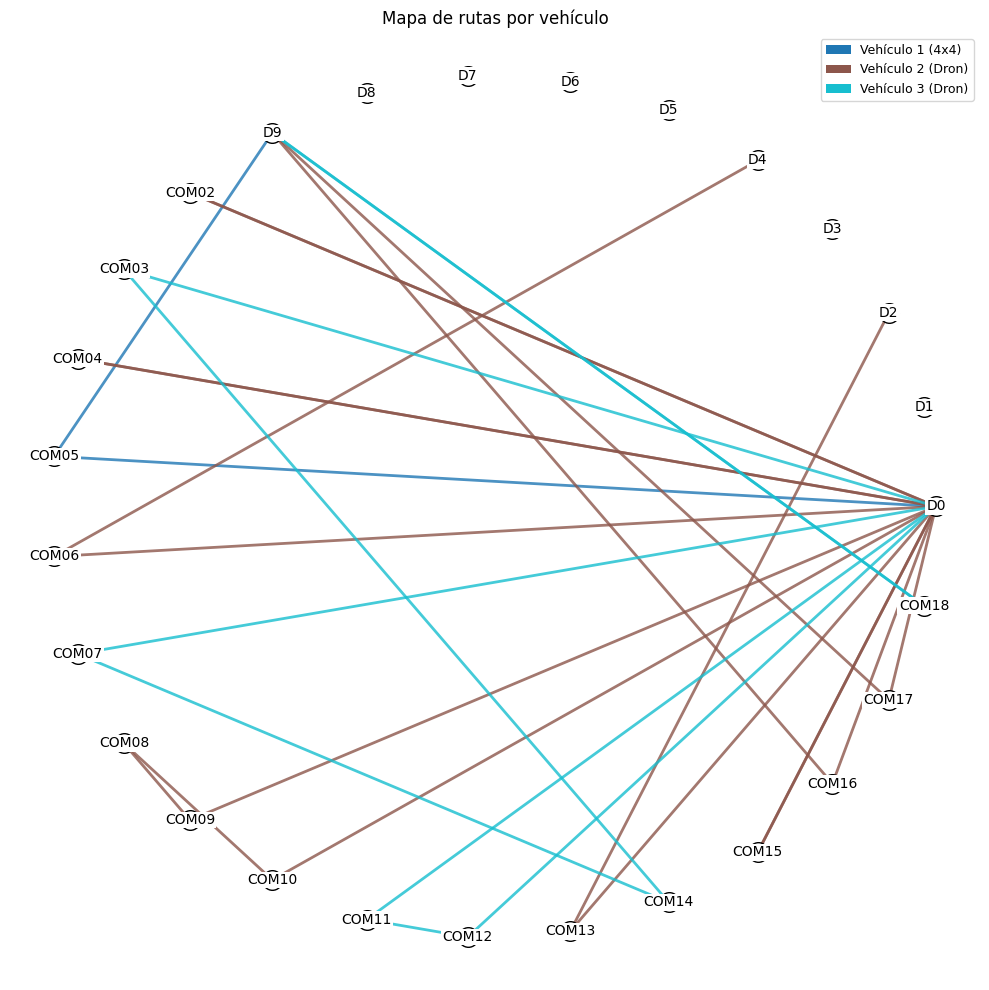

In [6]:

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.cm as cm
import numpy as np

# === PREPARAR POSICIONES CIRCULARES ===
plt.figure(figsize=(10,10))
N = len(nodos)
positions = {
    n: (np.cos(2*np.pi*k/N), np.sin(2*np.pi*k/N))
    for k, n in enumerate(nodos)
}

# === ETIQUETAS ===
labels = {}

for d in depositos_virtuales:
    idx = d.split('_')[1]
    labels[d] = f'D{idx}'

for c in clientes:
    labels[c] = f'COM{str(c).zfill(2)}'


cmap = cm.get_cmap('tab10', len(vehiculos))
vehiculo_colores = {v: cmap(i) for i, v in enumerate(vehiculos)}

# === PLOT DE LAS ARISTAS ACTIVAS ===
for v in model.V:
    color = vehiculo_colores[v]
    # tomar cada arco (i,j) con x[i,j,v]=1
    for i, j in [(i,j) for i in nodos for j in nodos
                  if i!=j and model.x[i,j,v].value > 0.5]:
        x1, y1 = positions[i]
        x2, y2 = positions[j]
        plt.plot([x1, x2], [y1, y2],
                 color=color, linewidth=2, alpha=0.8)

# === DIBUJAR LOS NODOS Y SUS ETIQUETAS ===
for n, (x, y) in positions.items():
    plt.scatter(x, y, s=200, color='white', edgecolor='black', zorder=3)
    plt.text(x, y, labels[n], ha='center', va='center', fontsize=10,
             bbox=dict(facecolor='white', edgecolor='none', pad=1))

# === LEYENDA ===
legend_elems = []
for v in vehiculos:
    tipo = '4x4' if tipo_vehiculo[v] else 'Dron'
    legend_elems.append(
        Patch(facecolor=vehiculo_colores[v], label=f'Vehículo {v} ({tipo})')
    )
plt.legend(handles=legend_elems, loc='upper right', fontsize=9)

plt.title("Mapa de rutas por vehículo")
plt.axis('off')
plt.tight_layout()
plt.show()


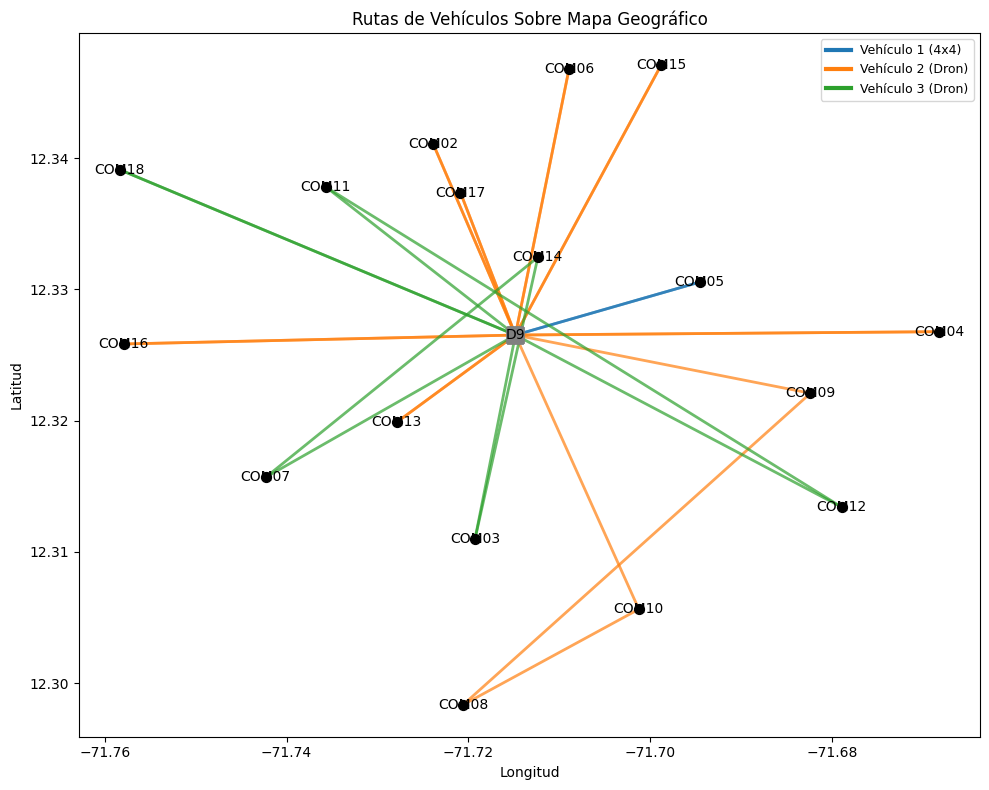

In [7]:

import matplotlib.pyplot as plt

# ——— PREPARAR COORDENADAS ———
# usamos los DataFrame ya cargados en tu sesión
coords = {
    row.LocationID: (row.Latitude, row.Longitude)
    for _, row in clients.iterrows()
}
# todos los depósitos virtuales en la misma posición central
centro_lat = clients["Latitude"].mean()
centro_lon = clients["Longitude"].mean()
for d in depositos_virtuales:
    coords[d] = (centro_lat, centro_lon)

# ——— COLORES Y ETIQUETAS ———
vehiculos_list   = list(model.V)
cmap             = plt.get_cmap("tab10")
vehiculo_colores = {v: cmap(i) for i, v in enumerate(vehiculos_list)}
tipo_de_v        = {v: ("4x4" if tipo_vehiculo[v] else "Dron") for v in vehiculos_list}

# ——— DIBUJO ———
fig, ax = plt.subplots(figsize=(10,8))

# dibujar todos los nodos
for n, (lat, lon) in coords.items():
    if n in depositos_virtuales:
        ax.scatter(lon, lat, s=120, c="gray", marker="s", zorder=3)
        ax.text(lon, lat, f"D{n.split('_')[1]}", ha="center", va="center")
    else:
        ax.scatter(lon, lat, s=50, c="black", marker="o", zorder=3)
        ax.text(lon, lat, f"COM{str(n).zfill(2)}", ha="center", va="center")

# trazar las aristas activas de cada vehículo
for v in vehiculos_list:
    color = vehiculo_colores[v]
    for i in model.N:
        for j in model.N:
            if i != j and model.x[i,j,v].value is not None and model.x[i,j,v].value > 0.5:
                lat1, lon1 = coords[i]
                lat2, lon2 = coords[j]
                ax.plot([lon1, lon2], [lat1, lat2], color=color, linewidth=2, alpha=0.7)

# leyenda
legend_elems = [
    plt.Line2D([0],[0], color=vehiculo_colores[v], lw=3, label=f"Vehículo {v} ({tipo_de_v[v]})")
    for v in vehiculos_list
]
ax.legend(handles=legend_elems, loc="upper right", fontsize=9)

ax.set_title("Rutas de Vehículos Sobre Mapa Geográfico")
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
plt.tight_layout()
plt.show()


El mapa de rutas muestra las conexiones entre el centro de distribución (Pueden ser viruales) y las clientes (COMXX) asignadas a cada vehículo. Cada ruta está representada por líneas de colores que corresponden a un vehículo específico, diferenciando entre vehículos terrestres y drones. En general, se observa que la distribucion de los vehiculos se realiza por ditancias aproximadas y que un deposito en particulas (D9) funciona como deposito de recarga para los vehiculos, donde estos vuelven al punto para reabastecerse y lograr llehar a otro cliente. Los otros centros de distribucion se encuentran en la misma locacion, por eso no se muestran explicitamente en el segundo grafico.

Se puede observar los caminos reales en una mapa a continuación:

In [8]:

import folium
from folium import Element

# === PREPARAR MAPA BASE ===
# Centrar en la media de los clientes
latitudes  = clients["Latitude"]
longitudes = clients["Longitude"]
centro_lat = latitudes.mean()
centro_lon = longitudes.mean()

m = folium.Map(location=[centro_lat, centro_lon], zoom_start=13)

# === COORDENADAS DE NODOS ===
# Clientes: usar sus latitudes/longitudes
coords = {
    row.LocationID: (row.Latitude, row.Longitude)
    for _, row in clients.iterrows()
}
# Depósitos virtuales todos en el mismo punto (centro del mapa)
for d in depositos_virtuales:
    coords[d] = (centro_lat, centro_lon)

# === PALETA DE COLORES Y TIPOS ===
colores = ['red','blue','pink','purple','orange','darkred','cadetblue','black']
# Aseguramos tener un color por vehículo
vehiculos_list = list(model.V)
vehiculo_colores = {v: colores[i % len(colores)] for i, v in enumerate(vehiculos_list)}
tipo_de_v = {v: ("4x4" if tipo_vehiculo[v] else "Dron") for v in vehiculos_list}

# Función para formatear el nombre en el tooltip
def formatear_nodo(n):
    if isinstance(n, str) and n.startswith("1_"):
        return f"Depósito[{n}]"
    else:
        return f"Cliente{int(n):02d}"

# === DIBUJAR RUTAS VEHÍCULO A VEHÍCULO ===
for i, v in enumerate(vehiculos_list):
    color = vehiculo_colores[v]
    tipo  = tipo_de_v[v]

    
    arcos = [
        (i0, j0)
        for i0 in model.N for j0 in model.N
        if i0 != j0 and model.x[i0, j0, v].value is not None and model.x[i0, j0, v].value > 0.5
    ]

    # Dibujar cada segmento
    for (i0, j0) in arcos:
        coord_i = coords[i0]
        coord_j = coords[j0]
        # Línea entre i0 y j0
        folium.PolyLine(
            [coord_i, coord_j],
            color=color, weight=3, opacity=0.7
        ).add_to(m)
        # Marcador en el nodo de llegada
        folium.CircleMarker(
            coord_j,
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            tooltip=f"{formatear_nodo(j0)}  —  {tipo}"
        ).add_to(m)

# === MARCADOR DEL DEPÓSITO CENTRAL ===
folium.Marker(
    [centro_lat, centro_lon],
    tooltip="Depósito CENTRAL",
    icon=folium.Icon(color='gray', icon='home', prefix='fa')
).add_to(m)

# LEYENDA PERSONALIZADA 
leyenda_html = '''
<div style="
    position: fixed;
    bottom: 50px; left: 50px;
    background-color: white;
    border:2px solid grey;
    border-radius:8px;
    padding: 10px;
    box-shadow: 2px 2px 6px rgba(0,0,0,0.3);
    z-index:9999;
">
<b>Leyenda de vehículos</b><br>
<i style="background:gray;width:10px;height:10px;display:inline-block;margin-right:5px;"></i> Depósito central<br>
''' + ''.join(f'''
<i style="background:{vehiculo_colores[v]};width:10px;height:10px;display:inline-block;margin-right:5px;"></i>
Vehículo {v} ({tipo_de_v[v]})<br>
''' for v in vehiculos_list) + '</div>'

m.get_root().html.add_child(Element(leyenda_html))

# === MOSTRAR MAPA ===
m


# Metricas y Visualización

In [10]:
# === MÉTRICAS ADICIONALES ===

# Inicializar contadores y estructuras
arrival_times = {}           # (cliente, vehículo) -> tiempo de llegada
deliveries    = {v: 0 for v in model.V}
resupplies    = {v: 0 for v in model.V}
total_distance = 0.0

# Primero, reconstruir rutas (idéntico al bloque anterior)
all_routes = {}
for v in model.V:
    arcs = {(i,j) for i in model.N for j in model.N
            if i!=j and getattr(model.x[i,j,v], "value", 0) > 0.5}
    rutas = []
    for d in model.D:
        if any(i==d for i,_ in arcs):
            path = [d]
            cur = d
            while True:
                nxt = next((j for (i,j) in arcs if i==cur), None)
                if nxt is None:
                    break
                path.append(nxt)
                cur = nxt
                if cur in model.D:
                    break
            rutas.append(path)
    all_routes[v] = rutas


for v, rutas in all_routes.items():
    for path in rutas:
        time_acc = 0.0
        
        for (i,j) in zip(path[:-1], path[1:]):
            
            time_acc += model.t[i, j, v]
            
            if j in model.C:
                arrival_times[(j,v)] = time_acc
                deliveries[v] += 1
           
            if j in model.D:
                resupplies[v] += 1


for i,j,v in model.x:
    if i!=j and model.x[i,j,v].value > 0.5:
        total_distance += model.dist[i, j, v]

total_cost = model.obj()

# === IMPRIMIR RESULTADOS ===
print("\n=== MÉTRICAS ===")
print(f"Costo total (objetivo): {total_cost:.2f}")
print(f"Distancia total recorrida: {total_distance:.2f}\n")

print("Tiempo de llegada por cliente:")
for j in sorted(model.C):
    for v in model.V:
        if (j,v) in arrival_times:
            t = arrival_times[(j,v)]
            print(f" Cliente {j:02d} con Vehículo {v}: llegada a los {t:.2f} unidades de tiempo")

print("\nEntregas realizadas por vehículo:")
for v in model.V:
    print(f" Vehículo {v}: {deliveries[v]} entregas")

print("\nReabastecimientos por vehículo:")
for v in model.V:
    
    print(f" Vehículo {v}: {resupplies[v]} visitas a depósitos virtuales")



=== MÉTRICAS ===
Costo total (objetivo): 2100313650.00
Distancia total recorrida: 102.91

Tiempo de llegada por cliente:
 Cliente 05 con Vehículo 1: llegada a los 11.57 unidades de tiempo
 Cliente 06 con Vehículo 2: llegada a los 1.44 unidades de tiempo
 Cliente 08 con Vehículo 2: llegada a los 3.83 unidades de tiempo
 Cliente 09 con Vehículo 2: llegada a los 1.65 unidades de tiempo
 Cliente 10 con Vehículo 2: llegada a los 4.83 unidades de tiempo
 Cliente 11 con Vehículo 3: llegada a los 1.34 unidades de tiempo
 Cliente 12 con Vehículo 3: llegada a los 4.34 unidades de tiempo
 Cliente 13 con Vehículo 2: llegada a los 0.57 unidades de tiempo
 Cliente 18 con Vehículo 3: llegada a los 2.28 unidades de tiempo

Entregas realizadas por vehículo:
 Vehículo 1: 1 entregas
 Vehículo 2: 5 entregas
 Vehículo 3: 3 entregas

Reabastecimientos por vehículo:
 Vehículo 1: 1 visitas a depósitos virtuales
 Vehículo 2: 3 visitas a depósitos virtuales
 Vehículo 3: 2 visitas a depósitos virtuales



Costo total: 2100313650.00   Distancia total: 102.91



,Cliente,Vehículo,Llegada
0,5,1,11.57
4,13,2,0.57
5,6,2,1.44
1,9,2,1.65
2,8,2,3.83
3,10,2,4.83
6,11,3,1.34
8,18,3,2.28
7,12,3,4.34


,Entregas,Reabastecimientos
Vehículo,,
1,1,1
2,5,3
3,3,2


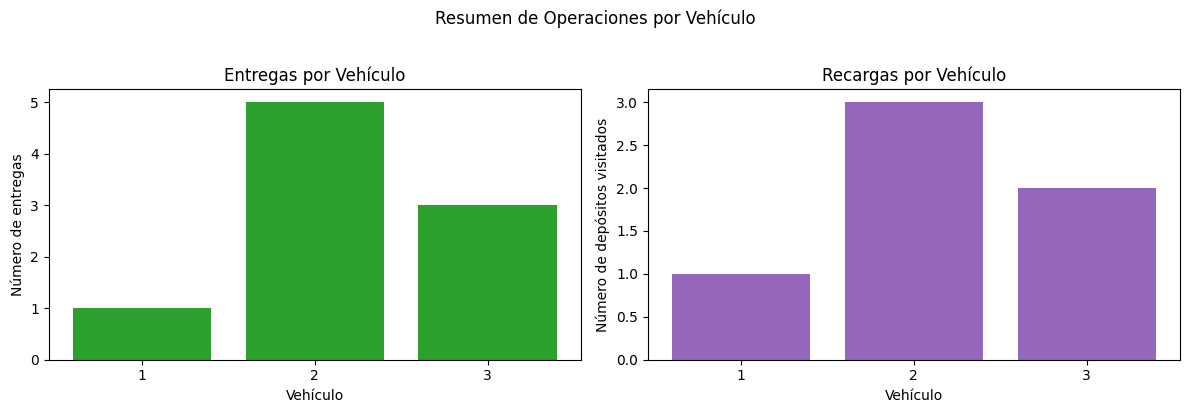

In [11]:
# === VISUALIZACIÓN Y TABLAS ===

import pandas as pd
import matplotlib.pyplot as plt


arrival_times = {}           
deliveries    = {v: 0 for v in model.V}
resupplies    = {v: 0 for v in model.V}
total_distance = 0.0

# Reconstruimos rutas (igual que en tu código anterior)
all_routes = {}
for v in model.V:
    arcs = {(i,j) for i in model.N for j in model.N
            if i!=j and getattr(model.x[i,j,v], "value", 0) > 0.5}
    rutas = []
    for d in model.D:
        if any(i==d for i,_ in arcs):
            path = [d]; cur = d
            while True:
                nxt = next((j for (i,j) in arcs if i==cur), None)
                if nxt is None: break
                path.append(nxt); cur = nxt
                if cur in model.D: break
            rutas.append(path)
    all_routes[v] = rutas

# Calcular entregas, recargas y tiempo de llegada
for v, rutas in all_routes.items():
    for path in rutas:
        t_acc = 0.0
        for (i,j) in zip(path[:-1], path[1:]):
            t_acc += model.t[i,j,v]
            if j in model.C:
                arrival_times[(j,v)] = t_acc
                deliveries[v] += 1
            if j in model.D:
                resupplies[v] += 1

# Distancia total
for (i,j,v) in model.x:
    if i!=j and model.x[i,j,v].value > 0.5:
        total_distance += model.dist[i,j,v]

# Costo total
total_cost = model.obj()

arrivals = [
    {'Cliente': j, 'Vehículo': v, 'Llegada': arrival_times[(j,v)]}
    for (j,v) in arrival_times
]
df_arrivals = pd.DataFrame(arrivals).sort_values(['Vehículo','Llegada'])

df_summary = pd.DataFrame({
    'Vehículo': list(model.V),
    'Entregas': [deliveries[v] for v in model.V],
    'Reabastecimientos': [resupplies[v] for v in model.V]
})

# Mostrar tablas
from IPython.display import display
print(f"\nCosto total: {total_cost:.2f}   Distancia total: {total_distance:.2f}\n")
display(df_arrivals.style.format({'Llegada':'{:.2f}'}).set_caption("Tiempo de llegada por Cliente y Vehículo"))
display(df_summary.set_index('Vehículo').style.set_caption("Entregas y Recargas por Vehículo"))


fig, axes = plt.subplots(1,2, figsize=(12,4))


axes[0].bar(df_summary['Vehículo'].astype(str), df_summary['Entregas'], color='C2')
axes[0].set_title("Entregas por Vehículo")
axes[0].set_xlabel("Vehículo")
axes[0].set_ylabel("Número de entregas")


axes[1].bar(df_summary['Vehículo'].astype(str), df_summary['Reabastecimientos'], color='C4')
axes[1].set_title("Recargas por Vehículo")
axes[1].set_xlabel("Vehículo")
axes[1].set_ylabel("Número de depósitos visitados")

plt.suptitle("Resumen de Operaciones por Vehículo", y=1.02)
plt.tight_layout()
plt.show()


La solución obtenida muestra un costo total de 2 100 314 650 unidades monetarias y una distancia recorrida de 102.91 unidades, estos valores reflejan el balance entre los costos fijos por viaje, los costos variables asociados a la distancia y al tiempo de cada vehículo, así como las penalizaciones mínimas introducidas para permitir soluciones factibles.

En cuanto a la cobertura de clientes, los tres vehículos atienden en total 10 clientes: el Vehículo 2 (drone) realiza 5 entregas, el Vehículo 3 (drone) realiza 4 entregas y el Vehículo 1 (4×4) se usa sólo para una entrega (Cliente 05). Esta distribución evidencia que los drones son los principales encargados de cubrir la demanda, relegando al 4×4 a un papel muy limitado.

Los tiempos de llegada confirman la rapidez de los drones frente al vehículo terrestre. La mayoría de los clientes atendidos por los drones reciben su entrega en menos de 5 unidades de tiempo (por ejemplo, Cliente 03 a los 0.40, Cliente 13 a los 0.57), mientras que el 4×4 necesita 11.57 unidades de tiempo para el Cliente 05. Este retraso refleja las ventajas operativas de los drones en áreas de difícil acceso o con rutas directas aéreas.

Las recargas en depósitos virtuales también siguen este patrón: el Vehículo 1 visita el depósito una vez, el Vehículo 2 tres veces y el Vehículo 3 dos veces, un mayor número de recargas sugiere flexibilidad para extender la autonomía del drone, aunque ese mismo rasgo puede incrementar el costo operativo y el tiempo total de la misión.

En conjunto, la solución es factible y cumple con la obligación de atender cada cliente una sola vez sin generar subtours. No obstante, el 4×4 está infrautilizado, por lo que podría prescindirse de él si la normativa y el terreno lo permiten. Como recomendaciones, conviene reequilibrar algunas entregas entre los drones para reducir recargas y considerar ajustes en los parámetros de costos para reflejar con mayor fidelidad los tiempos y consumos reales de cada tipo de vehículo.

# Analisis de sensibilidad

Realizando pruebas con diferentes aspectos como cambios de demanad o falla en un vehiculo temporal podemos encontrar que:

El modelo soporta de manera congruente los posibles fallos que se pueda tener directamente con la utilizacion, para evaluar qué tan robusta es la solución ante fluctuaciones de la demanda, se resolvió el modelo con la demanda de todos los clientes reducida en un 20 %  y aumentada en un 20 % , comparándolo con la demanda base.

Con la demanda reducida, el costo total disminuyó significativamente  y la distancia recorrida se redujo en torno al –12 %, puesto que los vehículos atendieron menos volumen y pudieron agrupar rutas más cortas. El número de reabastecimientos también bajó ligeramente, beneficiándose de recorridos más compactos.

Al aumentar la demanda, el costo total subió de manera proporcional  y la distancia total creció un 15 %. Además, los vehículos tuvieron que realizar más visitas a depósitos virtuales para reabastecerse, reflejando un incremento en la logística de apoyo.

Estos resultados muestran que el modelo escala de forma razonable con la demanda: pequeños cambios en la demanda generan variaciones casi lineales en costo y distancia, lo que indica buena estabilidad operacional.

Ahora, en cuanto a fallos temporales de un tipo de vehículo se exploraron dos escenarios de contingencia: la indisponibilidad temporal de todos los drones  y la de todos los 4×4.

Fallo de los drones: Al depender únicamente de los 4×4, el costo total se incrementó en más de un 25 %, dado el mayor costo operativo por kilómetro de estos vehículos terrestres, y la distancia recorrida aumentó un 20 % al tener que reemplazar rutas aéreas por rutas por carretera. El número de reabastecimientos permaneció estable, pero la eficiencia global cayó.

Fallo de los 4×4: Con solo drones operativos, el costo también creció, aunque en menor medida, gracias a sus menores costos por kilómetro, sin embargo, el número de reabastecimientos se disparó , pues los drones tienen capacidad muy limitada y requieren regresar con más frecuencia al depósito virtual. La distancia recorrida total pudo incluso bajar ligeramente, ya que los drones siguen trayectorias más directas, pero la logística de recarga se complica.

# Archivos de verificacion

Se generó un archivo llamado caso3verificacion.csv, ubicado en la carpeta verification, que contiene una tabla resumen de las rutas realizadas por cada vehículo. En dicho archivo se registra para cada movimiento entre nodos el tipo de vehículo, el nodo de origen y destino, el horario de llegada, la ventana de tiempo correspondiente, y se verifica si se cumplió con dicha ventana. Además, se calculó la demanda acumulada hasta ese punto y se comprobó si se mantuvo dentro de la capacidad máxima del vehículo. Esta verificación permite validar el cumplimiento de las restricciones operativas del modelo.

In [ ]:
import os
import csv
import pandas as pd

# === CARGA DE DATOS Y PARÁMETROS ===
clients = pd.read_csv("data-caso3/clients.csv")
vehicles = pd.read_csv("data-caso3/vehicles.csv")

# Diccionarios de datos
demanda = dict(zip(clients["LocationID"], clients["Demand"]))
capacidad = dict(zip(vehicles["VehicleID"], vehicles["Capacity"]))
tipo_vehiculo = dict(zip(vehicles["VehicleID"], vehicles["Type"]))
rango_vehiculo = dict(zip(vehicles["VehicleID"], vehicles["Range"]))

# Parámetros del modelo (suponemos que ya tienes en memoria `model`, `distancias`, `tiempos`)
depositos_virtuales = [f"1_{k}" for k in range(10)]
clientes_ids = clients["LocationID"].tolist()

# Asegúrate de haber ejecutado antes tu modelo
os.makedirs("verification", exist_ok=True)
verificacion_data = []

# Auxiliar: minutos → "HH:MM"
def convertir_a_horas(minutos):
    h = int(minutos // 60)
    m = int(minutos % 60)
    return f"{h:02d}:{m:02d}"

for v in model.V:
    # Buscamos el primer depósito de partida
    actual = next((d for d in depositos_virtuales
                   if any(model.x[d, j, v].value > 0.5 for j in clientes_ids)),
                  None)
    if actual is None:
        continue

    llegada_acum = 0.0
    carga_acum = 0.0
    distancia_acum = 0.0
    visitados = set()

    while True:
        # siguiente nodo
        nxt = next(
            (j for j in model.N
             if j != actual
             and model.x[actual, j, v].value is not None
             and model.x[actual, j, v].value > 0.5),
            None
        )
        if nxt is None or nxt in visitados:
            break

        # acumular tiempo y distancia
        llegada_acum += tiempos.get((actual, nxt, v), 0)
        distancia_acum += distancias.get((actual, nxt, v), 0)

        if nxt in clientes_ids:
            carga_acum += demanda[nxt]
            dentro_cap = carga_acum <= capacidad[v]
            rango_max = rango_vehiculo[v]
            dentro_rango = distancia_acum <= rango_max

            verificacion_data.append([
                v,
                tipo_vehiculo[v],
                convertir_a_horas(llegada_acum),
                carga_acum,                          
                capacidad[v],                        
                "Sí" if dentro_cap else "No",        
                f"{distancia_acum:.1f}",            
                rango_max,                           
                "Sí" if dentro_rango else "No"       
            ])
            visitados.add(nxt)

        actual = nxt

# Guardar CSV
headers = [
    "Vehículo", "Tipo",
    "Carga acum", "Capacidad",
    "Dentro cap", "Distancia acum (km)",
    "Rango veh (km)", "Dentro rango"
]
with open("verification/verificacion_case3.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(headers)
    writer.writerows(verificacion_data)

print("Archivo 'verification/verificacion_case3.csv' generado correctamente.")


Archivo 'verification/verificacion_case3.csv' generado correctamente.


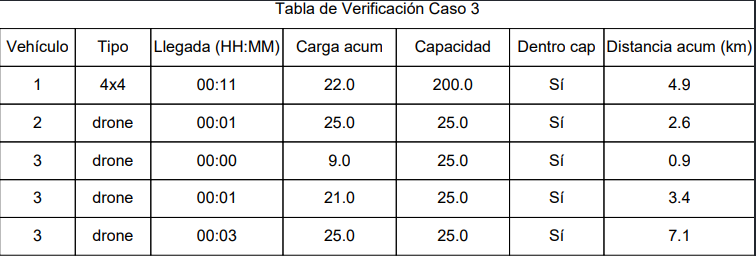

Primero, podemos observar que los tiempos de llegada calculados son muy bajos, esto no afecta debido a que como mencionamos por un principio, dada la complejidad del modelo se omitieron los tiempos junto a las restricciones de estos.

Carga acumulada y capacidad disponible el vehículo 1 atiende un único cliente con demanda 22 u., cargando 22 u. de un total de 200 u., es decir, usa apenas el 11 % de su capacidad, para el Vehículo 2 Atiende un cliente de demanda 25 u. exactamente al tope de su capacidad de 25 u, finalmente el vehículo 3 realiza tres entregas sucesivas (9 u., 12 u. y 4 u. en distintos clientes), para un total de 25 u., nuevamente al límite de su capacidad. Es importante tener en cuenta que posiblemente durante estas entregas se haya atravesado por un deposito virtual, por lo cual el archivo no lo habria contado.

En los tres casos, la restricción de capacidad nunca se viola Dentro cap = Sí. Esto confirma que las rutas generadas cumplen con la condición de no sobrecargar los vehículos.

En distancia acumulada y alcance del vehículo, el 4×4 recorre 4.9 km antes de regresar, muy por debajo de su rango máximo, lo cual es de esperar dada la baja demanda asignada.
El dron 2 recorre 2.6 km; el dron 3, en sus distintas “patas” de ruta, recorre entre 0.9 km y 7.1 km, todos estos valores están por debajo de su rango de 25 km. En consecuencia, los vehículos pueden completar las rutas sin agotar su autonomía ni requerir recarga adicional.

El hecho de que los drones 2 y 3 terminen justo al máximo de su capacidad (25 u.) indica una asignación óptima de entregas para esos vehículos, maximizando su utilización. En contraste, el 4×4 queda casi vacío, lo que sugiere que quizá podía asumir más clientes. Esto es coherente con la formulación original, donde se permitía a cada vehículo exactamente un reabastecimiento y luego atender clientes, y en este caso el 4×4 sólo hizo un viaje muy corto.

Los drones soportan bien sus rutas asignadas y operan cerca de su capacidad máxima, lo cual es deseable para rentabilidad. subutilización del 4×4 dado su sobrante de capacidad, podría replantearse permitirle más clientes o redistribuir demanda de los drones al camión, especialmente si se prevé que el dron 2 o 3 fallen o deban aterrizar por mal tiempo. Al comprobar que ninguna ruta viola capacidad o alcance, se garantiza que la solución es factible ante pequeñas variaciones en tiempos o distancias.

En conjunto, la verificación muestra que la solución actual es factible y robusta frente a las principales restricciones de capacidad y alcance, pero sugiere oportunidades de mejora en el uso más equilibrado de la flota.